In [1]:
from superoscillations import *
import matplotlib.pyplot as plt

## Loading pulse for sample 1: no lactose

In [2]:
pulses = pd.read_excel('original wave.xlsx', dtype=np.float)

timecol = 'Time (ps)'

# extract time colums and delet it
times = pulses[timecol].to_numpy()
pulses.drop(columns=[timecol], inplace=True)

pulses.columns

Index(['f=0.4 THz', 'f=0.5 THz', 'f=0.6 THz', 'f=0.7 THz', 'f=0.8 THz',
       'f=0.9 THz', 'f=1.0 THz', 'f=1.1 THz', 'f=1.2 THz', 'f=2.0 THz'],
      dtype='object')

In [3]:
pulses = pulses[
    ['f=0.4 THz', 'f=0.5 THz', 'f=0.6 THz', 'f=0.7 THz', 'f=0.8 THz']
]

In [4]:
sample_no_lactose = CTSuperoscillations(pulses, times)

## Loading pulse for sample 2: lactose

In [5]:
pulses = pd.read_excel('transmitted wave.xlsx', dtype=np.float)

print(pulses.shape)

pulses = pulses[
    ['f=0.4 THz', 'f=0.5 THz', 'f=0.6 THz', 'f=0.7 THz', 'f=0.8 THz']
]

sample_lactose = CTSuperoscillations(pulses[:sample_no_lactose.times.size], times)

del pulses

# consistency check
assert all(sample_no_lactose.pulses.columns == sample_lactose.pulses.columns)

(131072, 10)


In [6]:
def plot_pulses(df):
    """
    Plot pulses saved in DataFrame dt
    """
    for colname in df.columns:        
        
        plt.plot(times, df[colname], label=colname)

    plt.ylabel('electric field')
    plt.xlabel(timecol)
    plt.legend(loc='right')

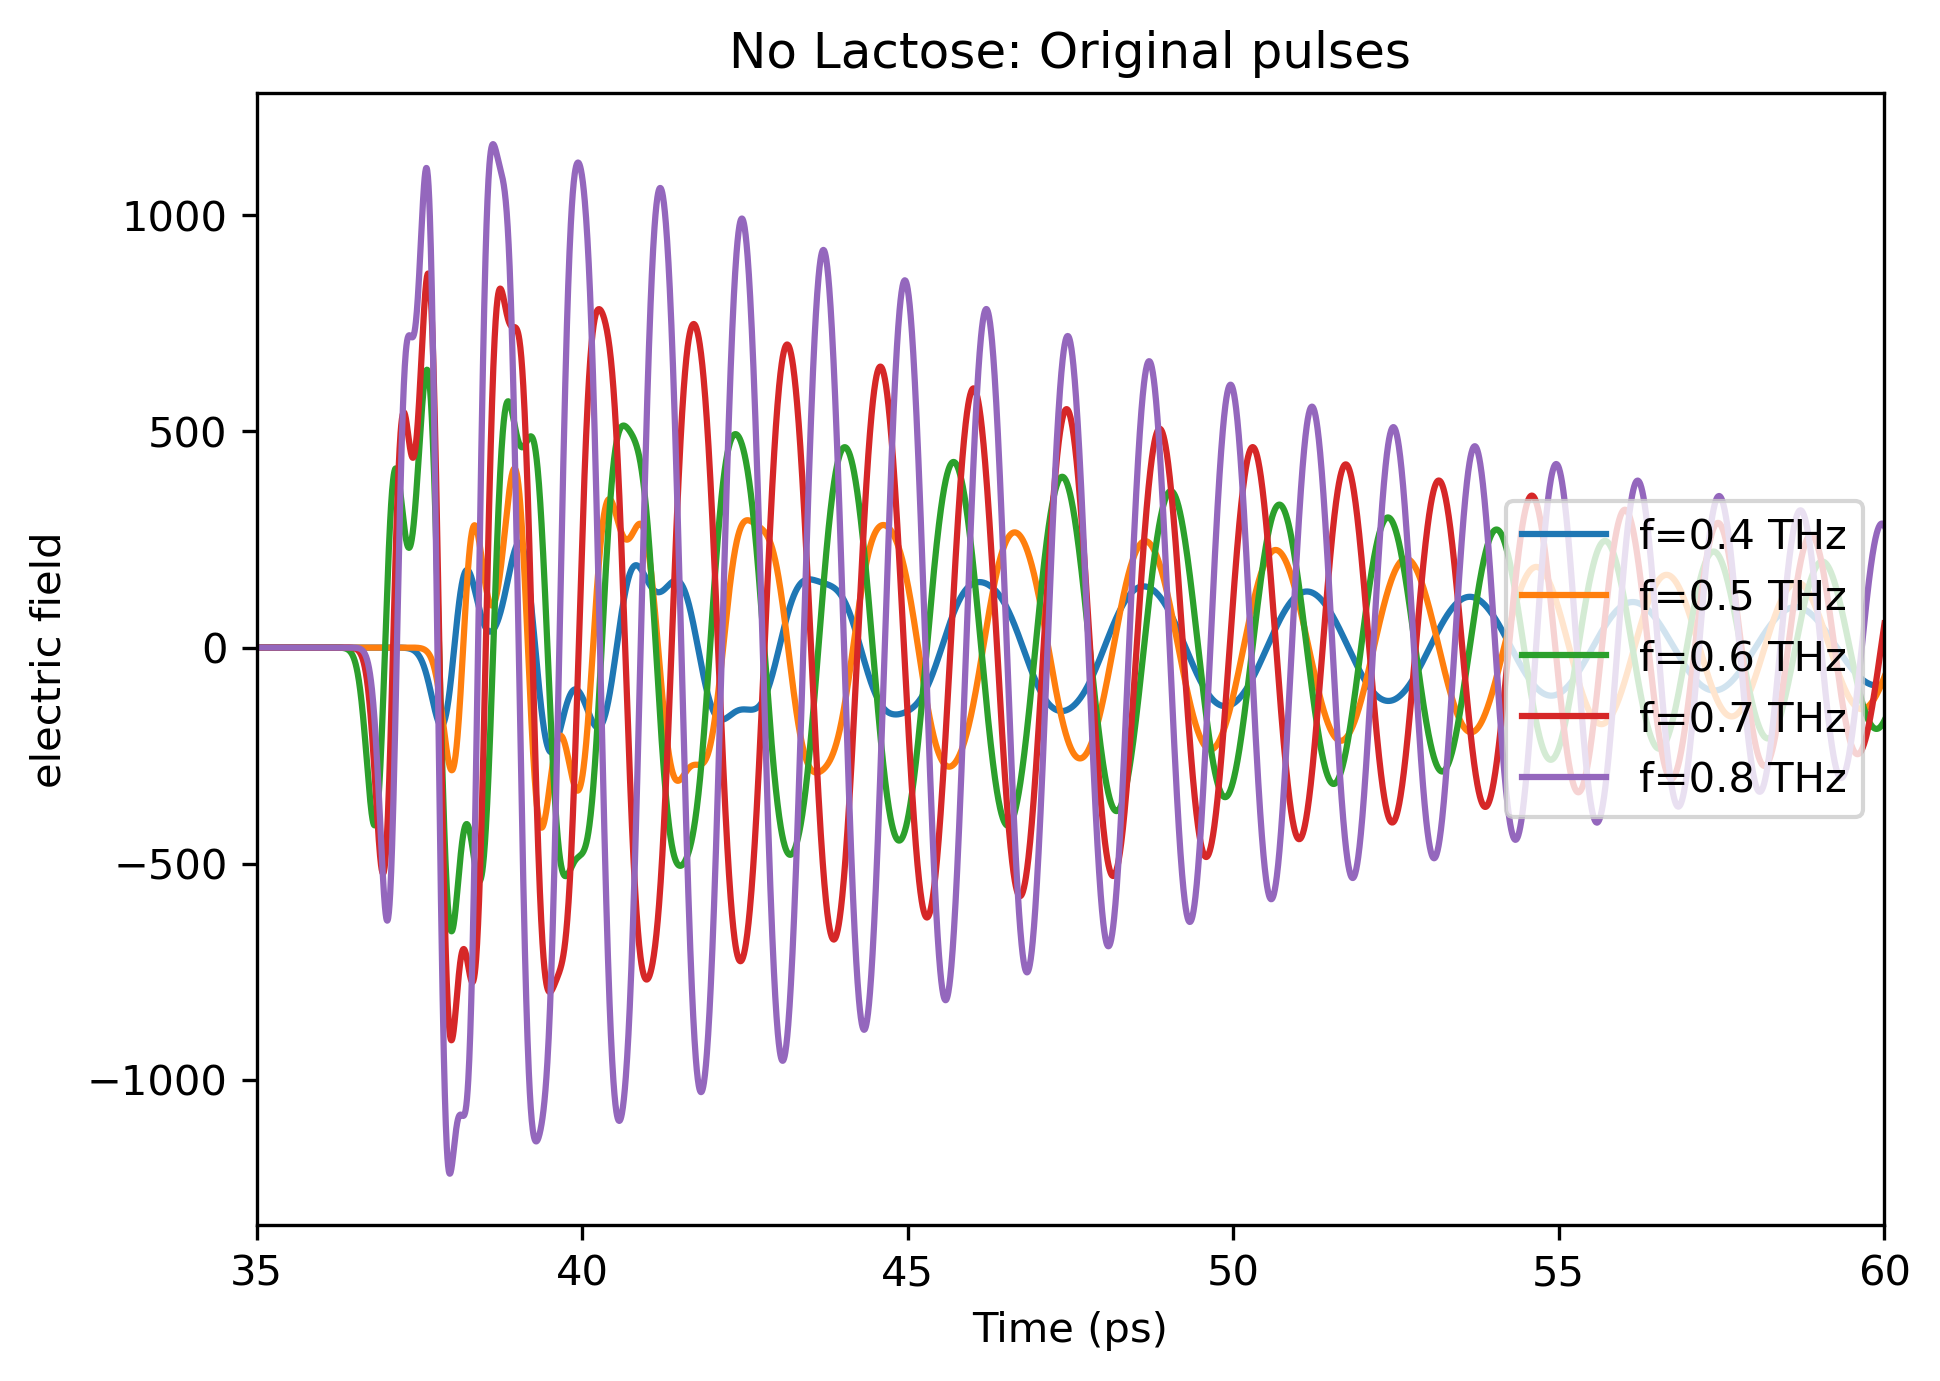

In [7]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([35, 60])
plt.title('No Lactose: Original pulses')
plot_pulses(sample_no_lactose.pulses)
#plt.savefig("original_pulses.pdf", transparent=True)
plt.show()

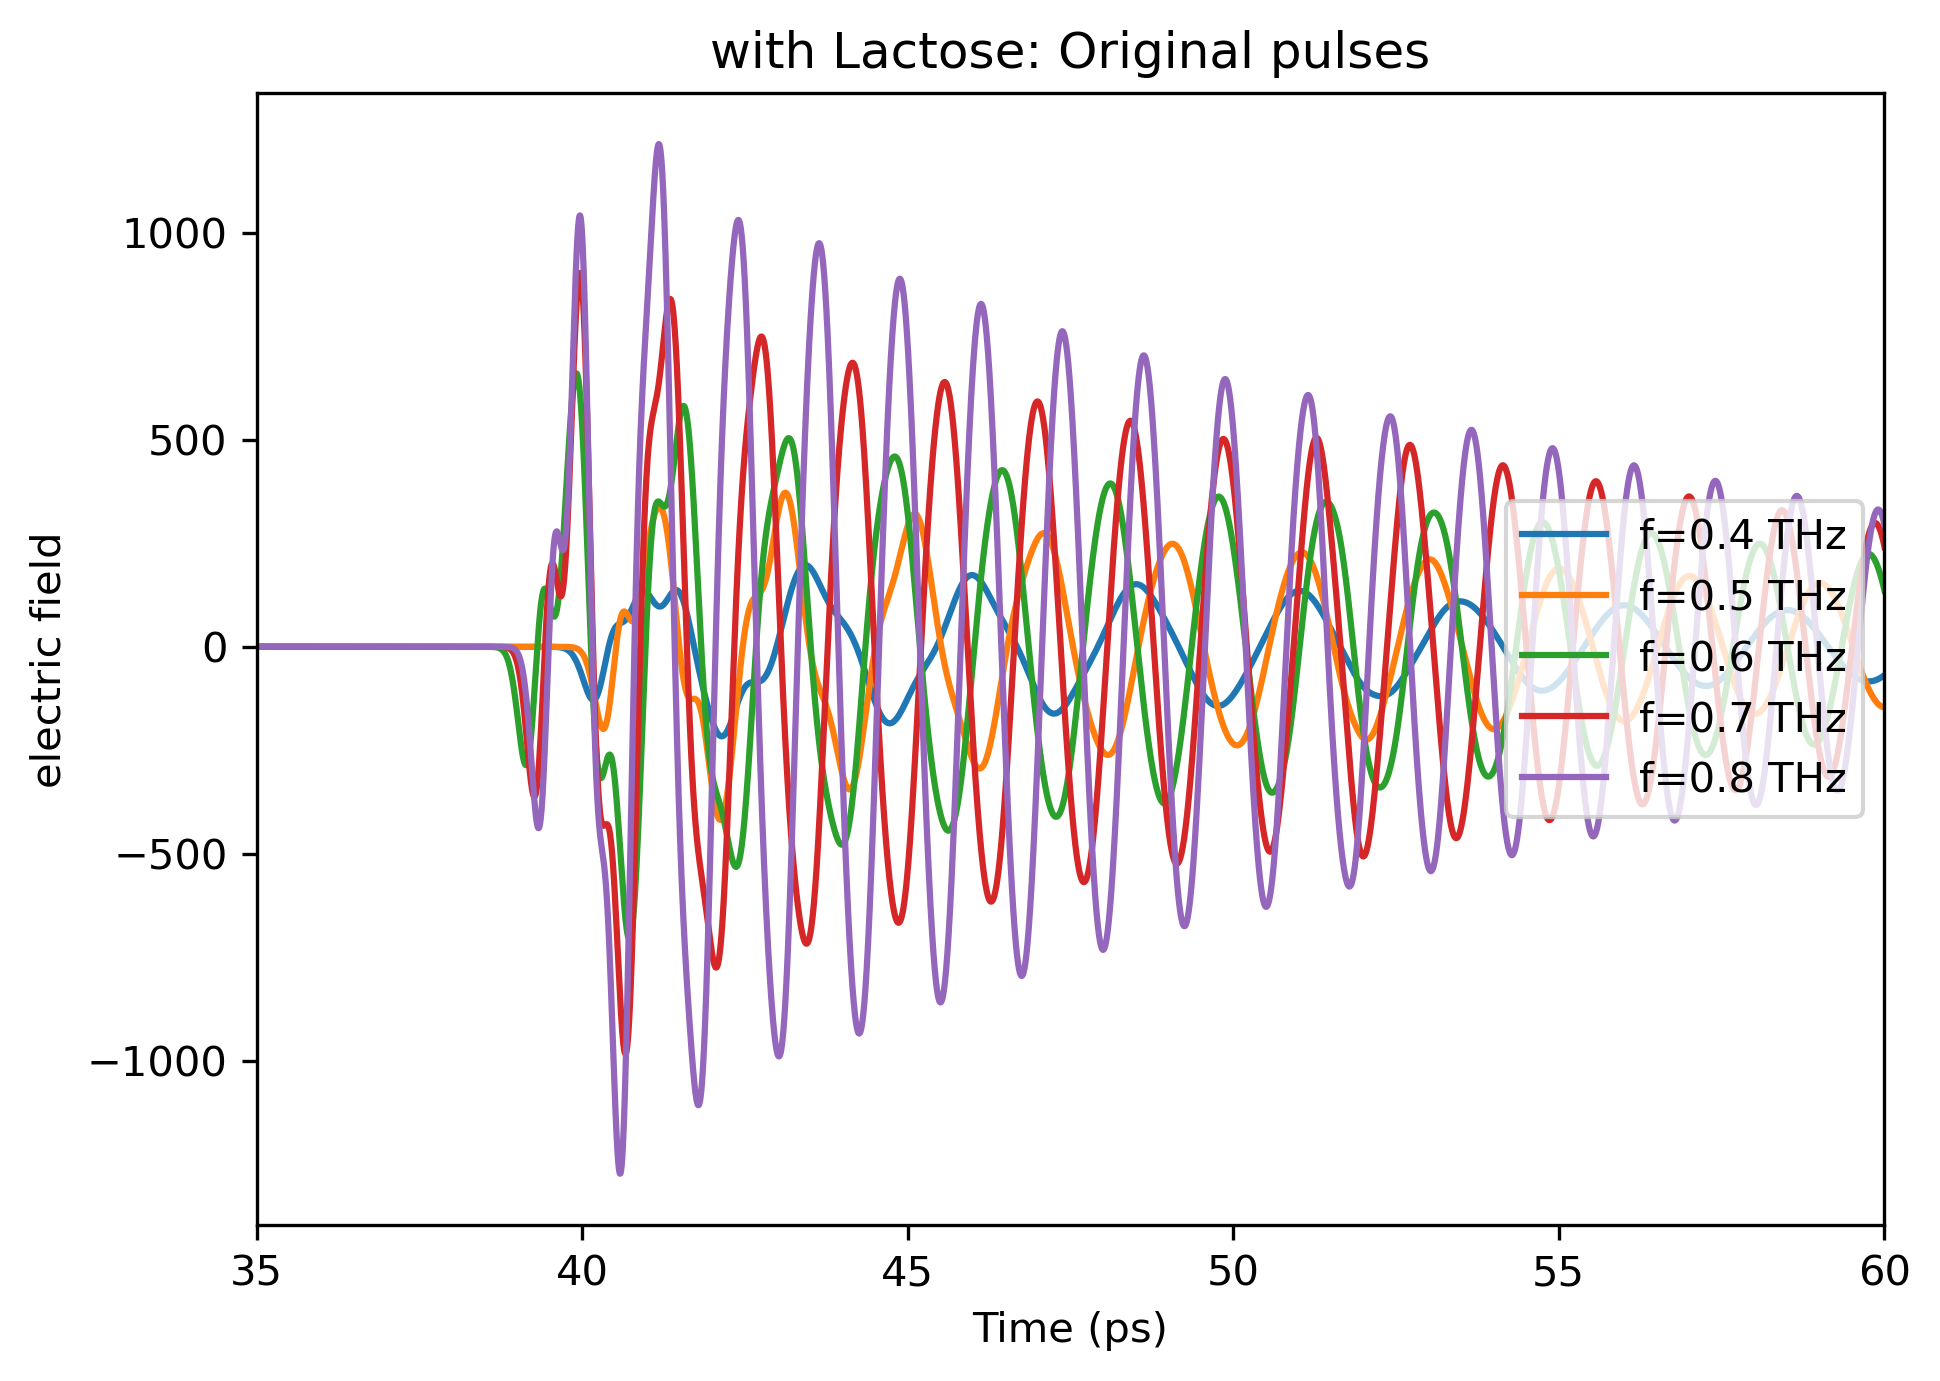

In [8]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([35, 60])
plt.title('with Lactose: Original pulses')
plot_pulses(sample_lactose.pulses)
#plt.savefig("original_pulses.pdf", transparent=True)
plt.show()

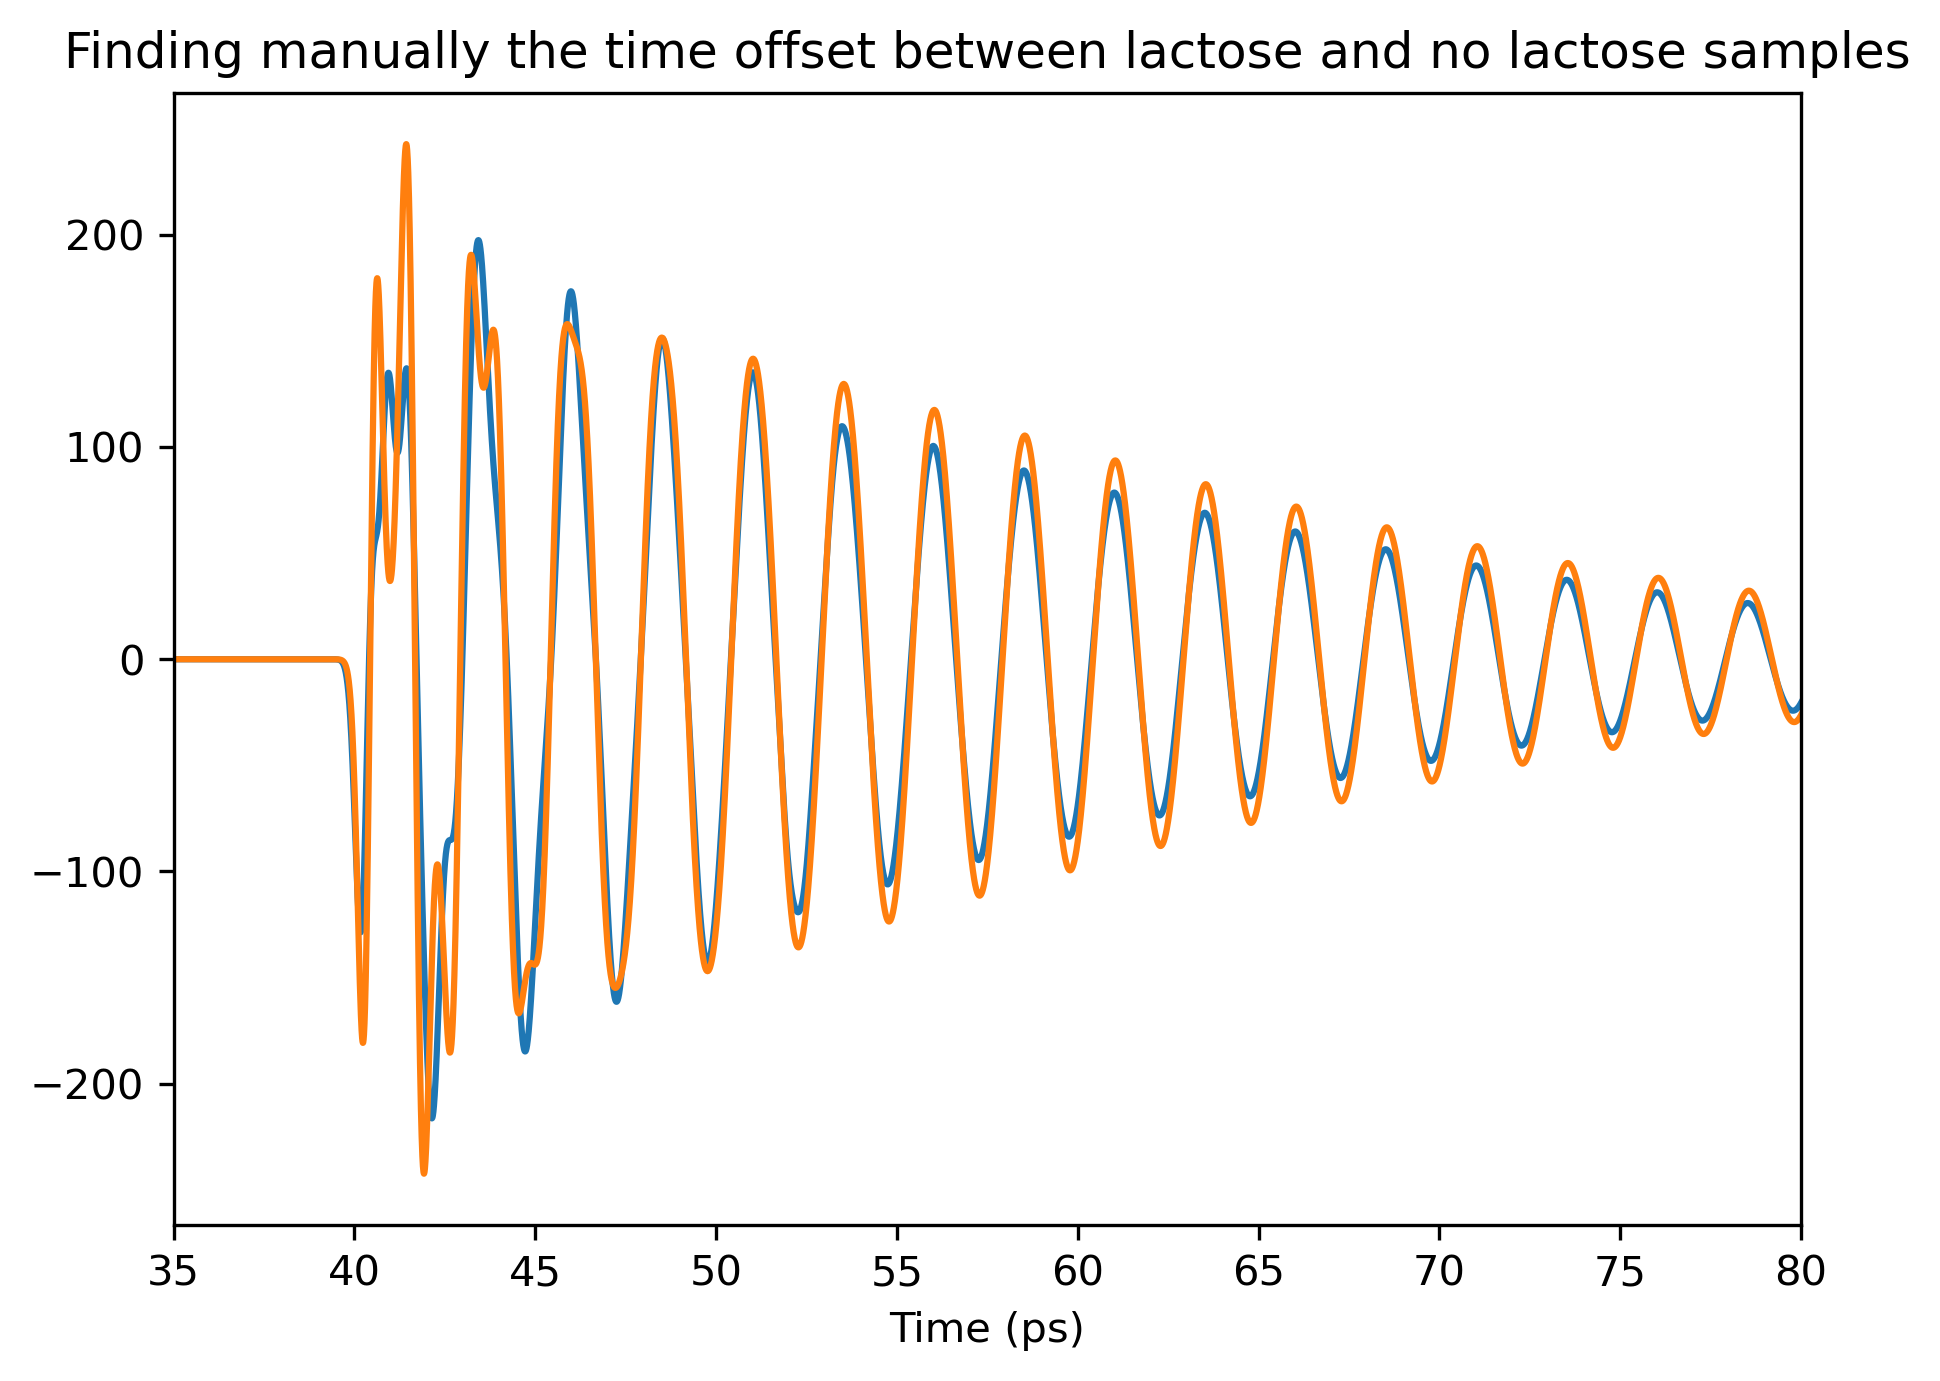

In [9]:
plt.figure(figsize=(7, 5), dpi=300)
plt.xlim([35, 80])
plt.title('Finding manually the time offset between lactose and no lactose samples')

plt.plot(times, sample_lactose.pulses['f=0.4 THz'])

offset = 480

plt.plot(
    times, 
    np.roll(sample_no_lactose.pulses['f=0.4 THz'], offset)
)

plt.xlabel(timecol)

plt.show()

In [10]:
#  Time align pulses

# Time align pulses from the no lactose sample
sample_no_lactose.time_align_pulses()

pulse_shifts = {
    colname: shift + offset 
    for colname, shift in sample_no_lactose.pulse_shifts.items()
}

# apply the same time alignment on the sample with lactose
sample_lactose.time_align_pulses(pulse_shifts)

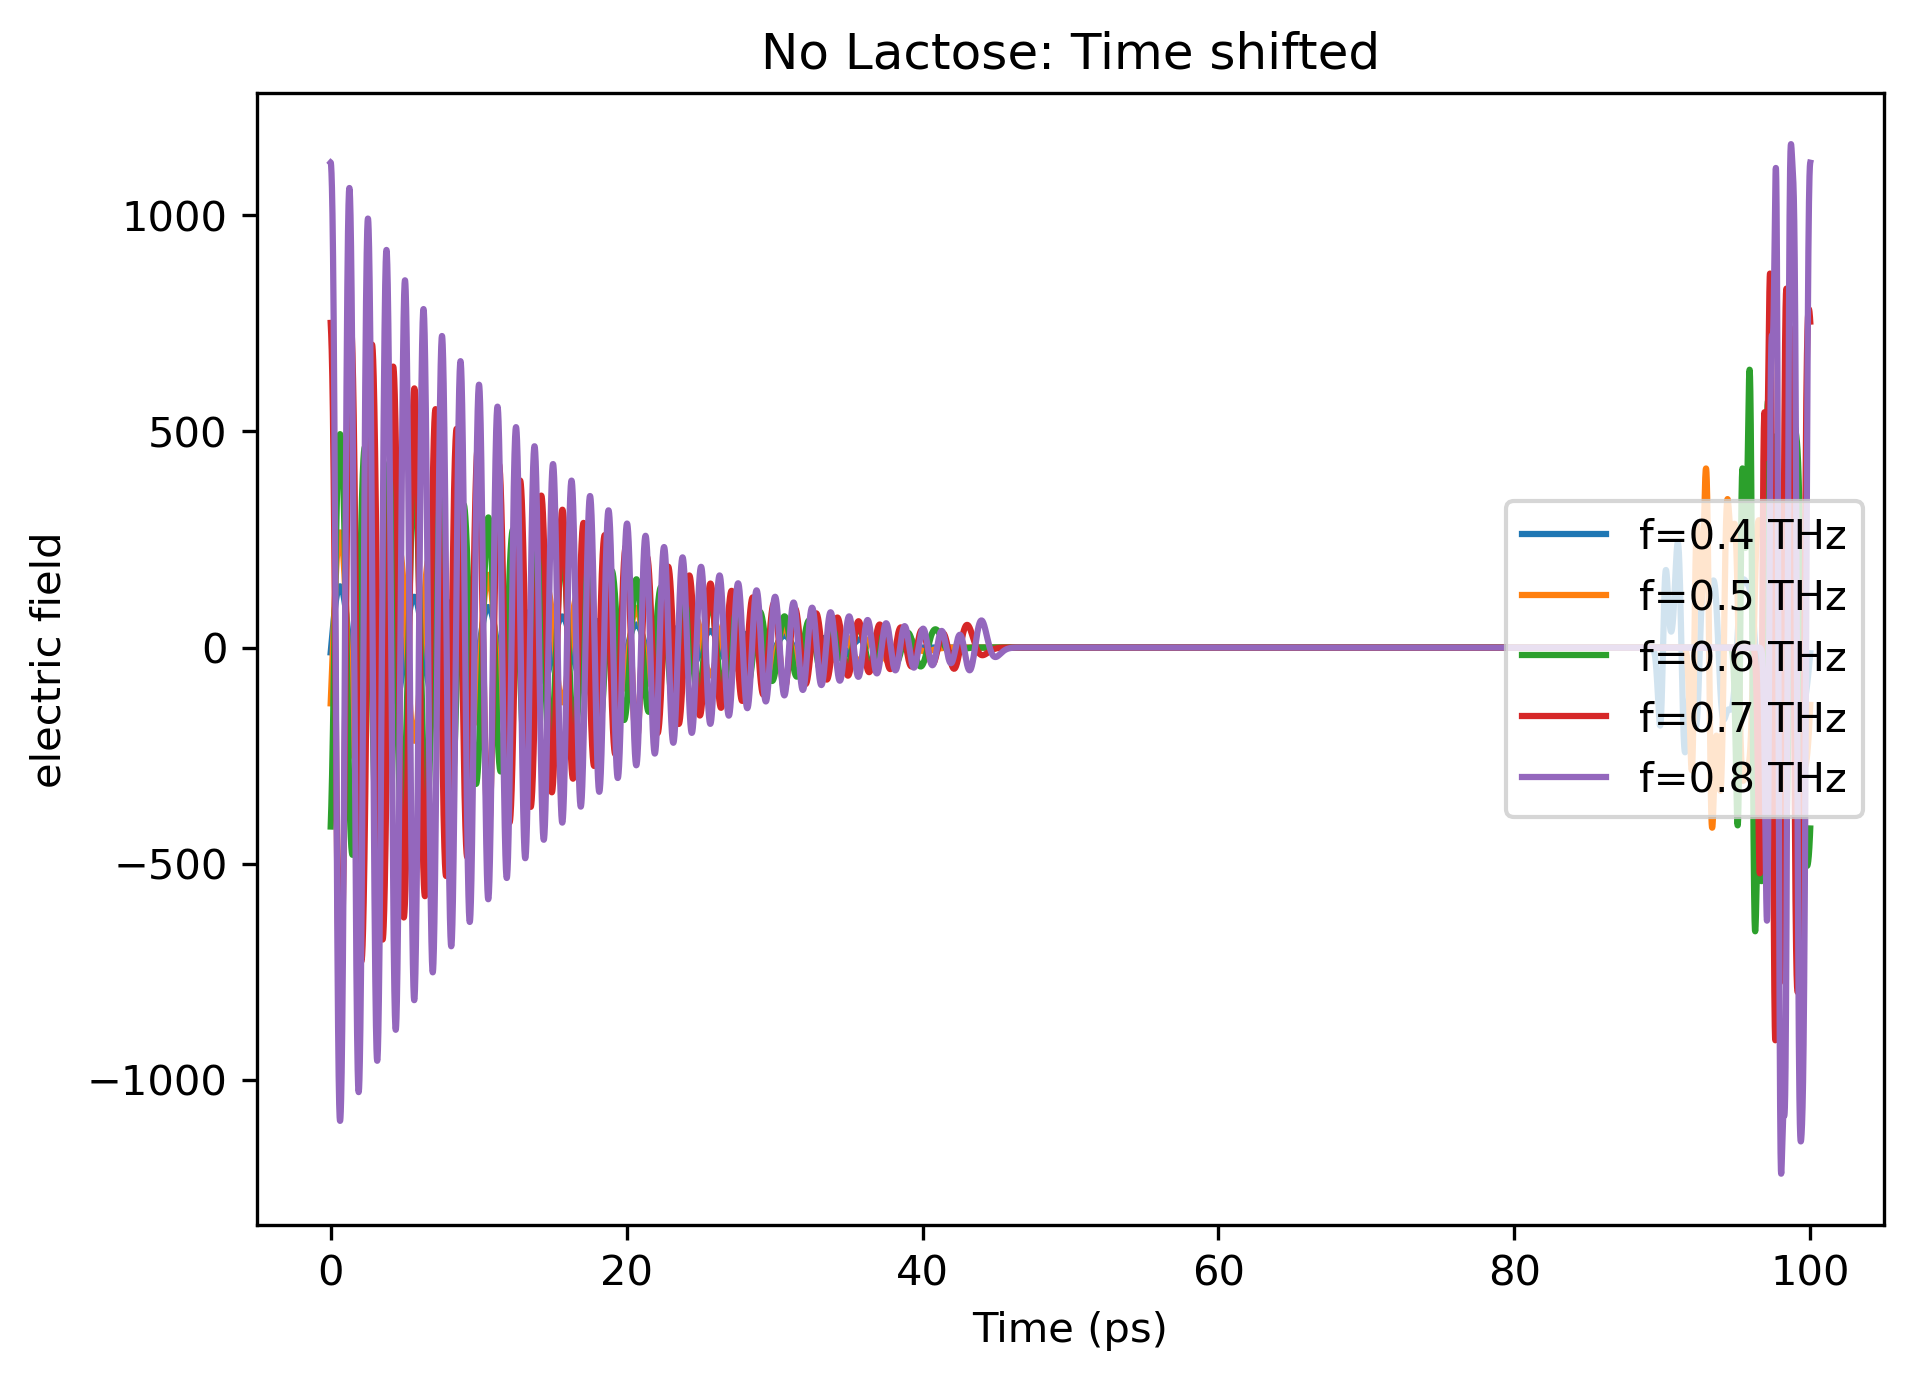

In [11]:
plt.figure(figsize=(7, 5), dpi=300)
#plt.xlim([0, 3])
plt.title('No Lactose: Time shifted')
plot_pulses(sample_no_lactose.pulses)
#plt.savefig("original_pulses.pdf", transparent=True)
plt.show()

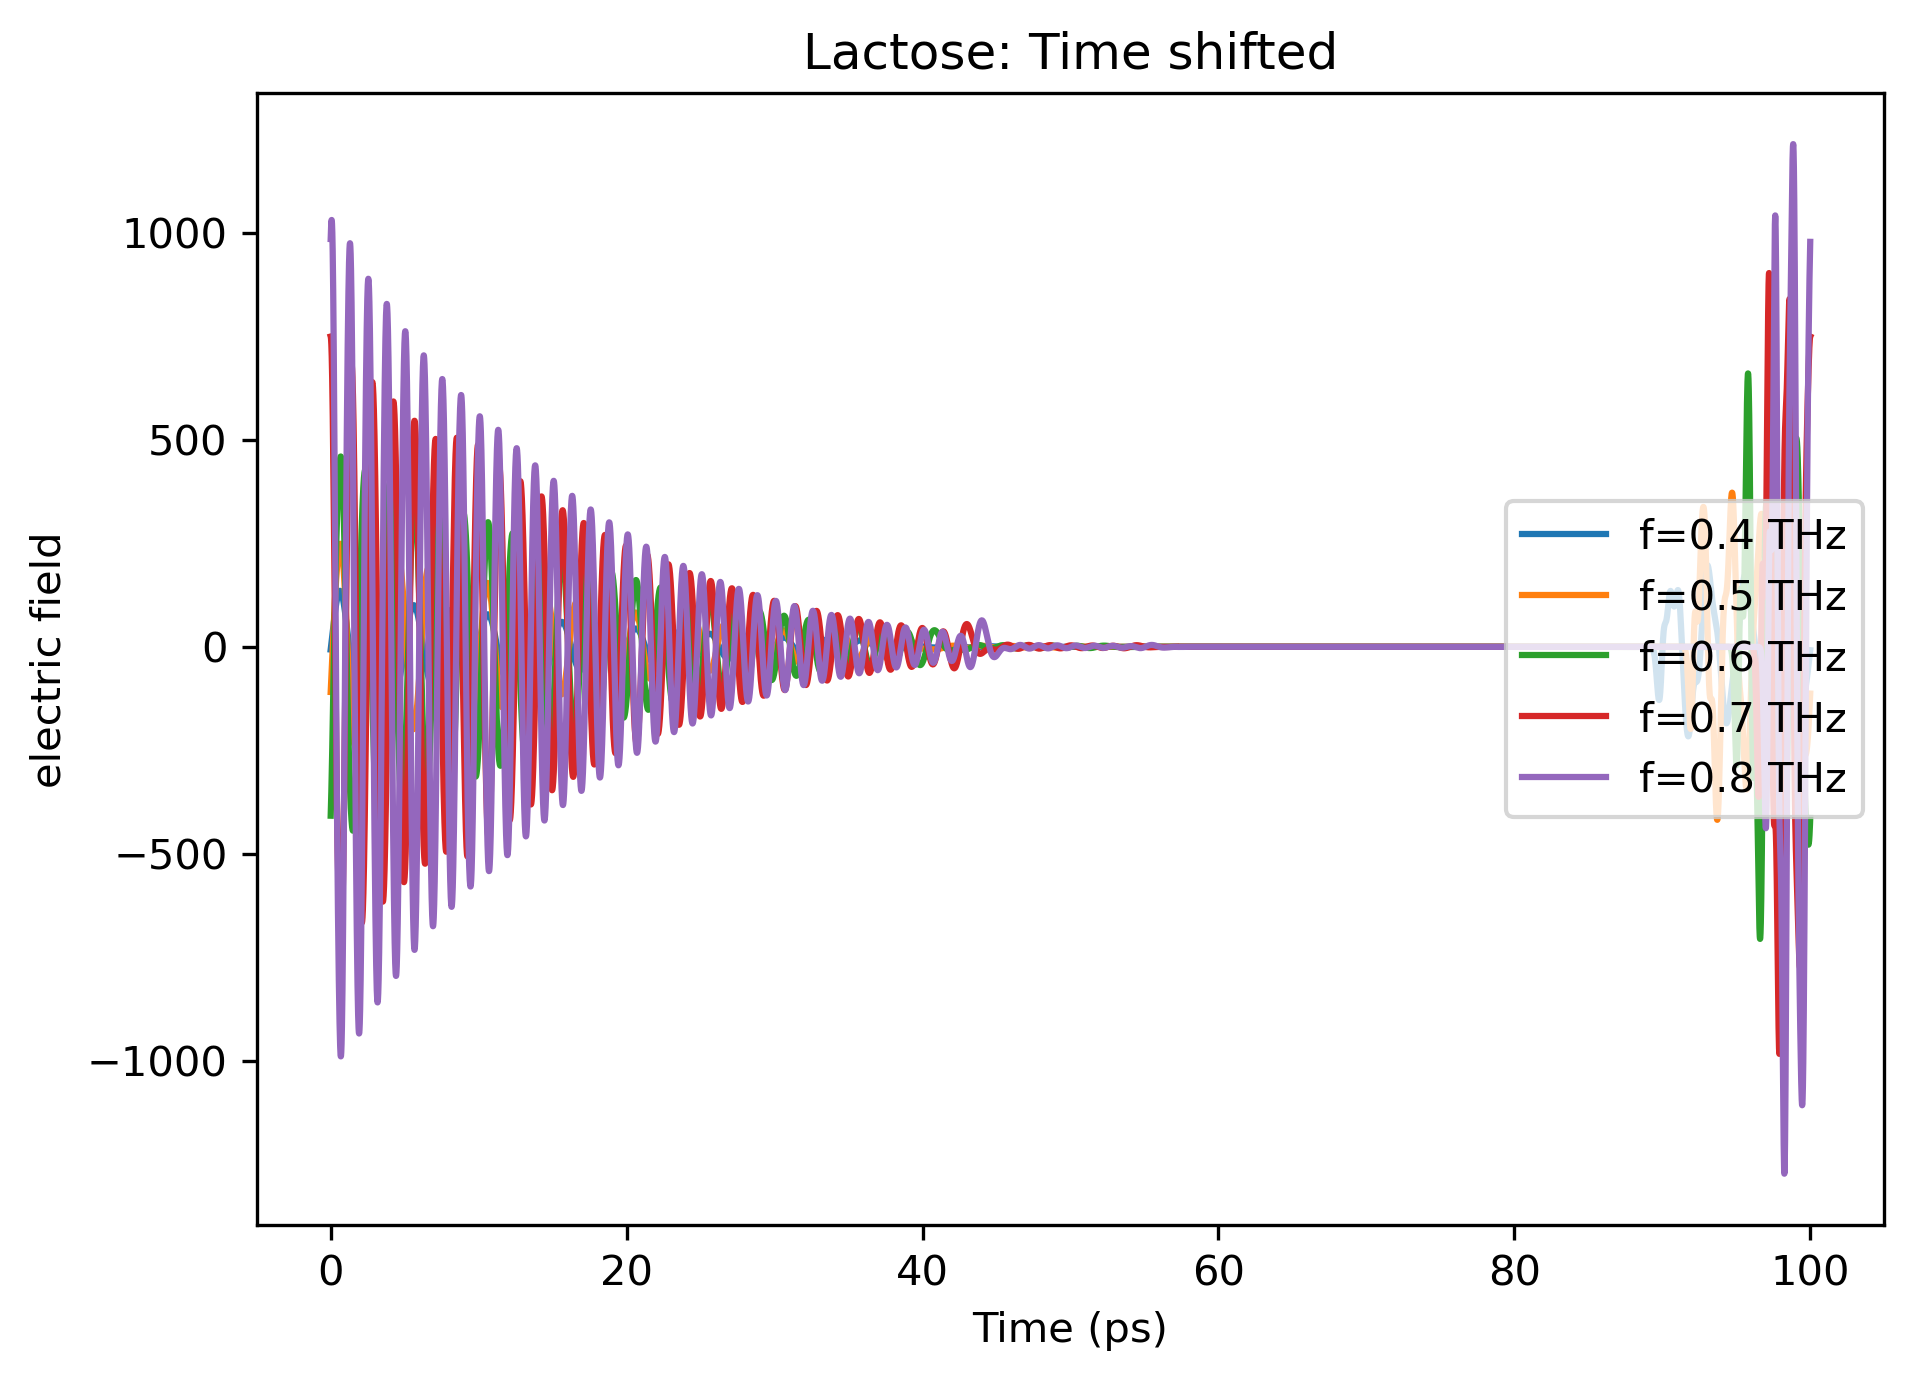

In [12]:
plt.figure(figsize=(7, 5), dpi=300)
#plt.xlim([0, 10])
plt.title('Lactose: Time shifted')
plot_pulses(sample_lactose.pulses)
#plt.savefig("original_pulses.pdf", transparent=True)
plt.show()

## Analyzing a single value of the observational window

In [38]:
observational_window = 1 * sample_no_lactose.observational_window

delta_pulses = sample_no_lactose.pulses - sample_lactose.pulses

S_observ = get_overlap(
    delta_pulses[:observational_window], 
    times[:observational_window]
)

In [39]:
# Finding optimal strategies for generating supperoscilations via eigenvectors
vals, vecs = eigh(S_observ, sample_no_lactose.S_infty)

(5,)


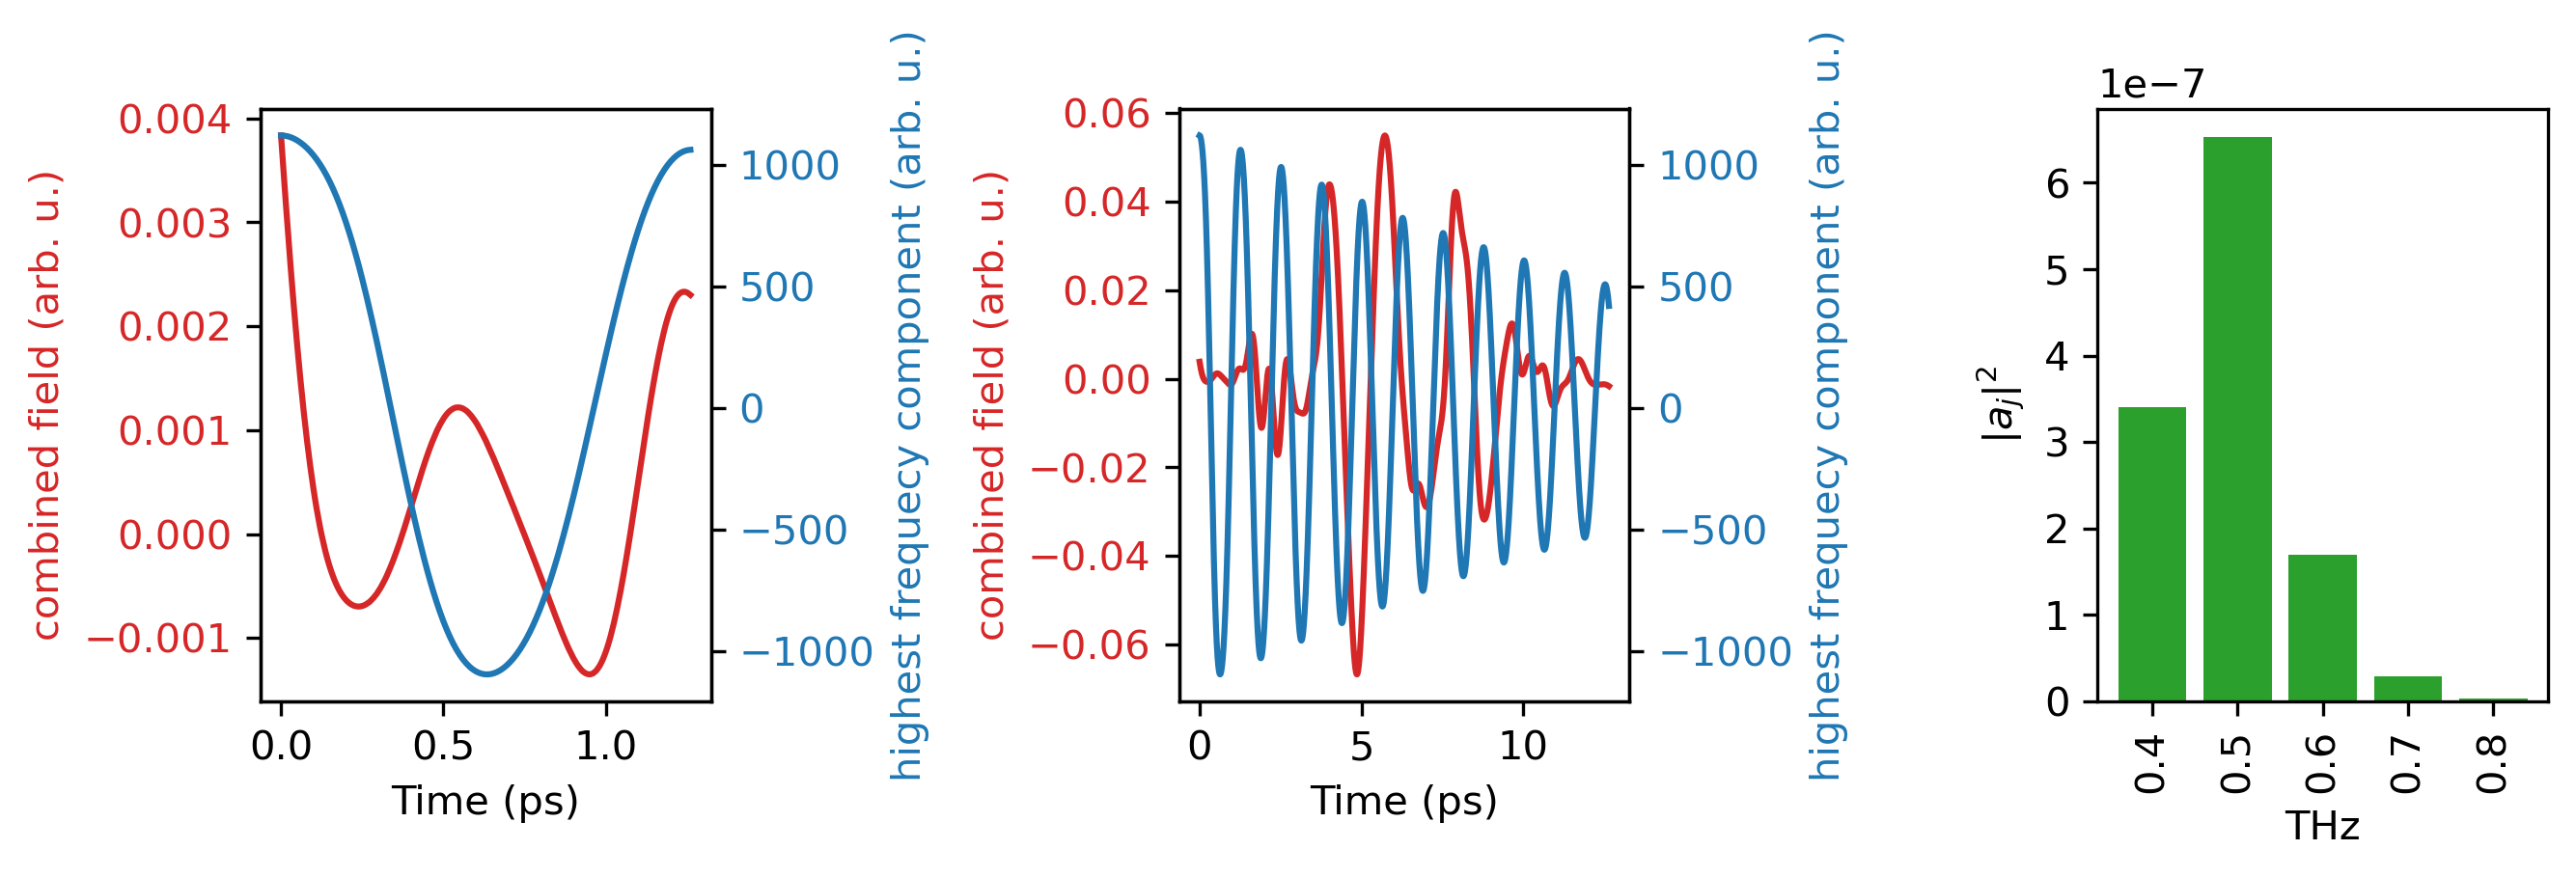

(5,)


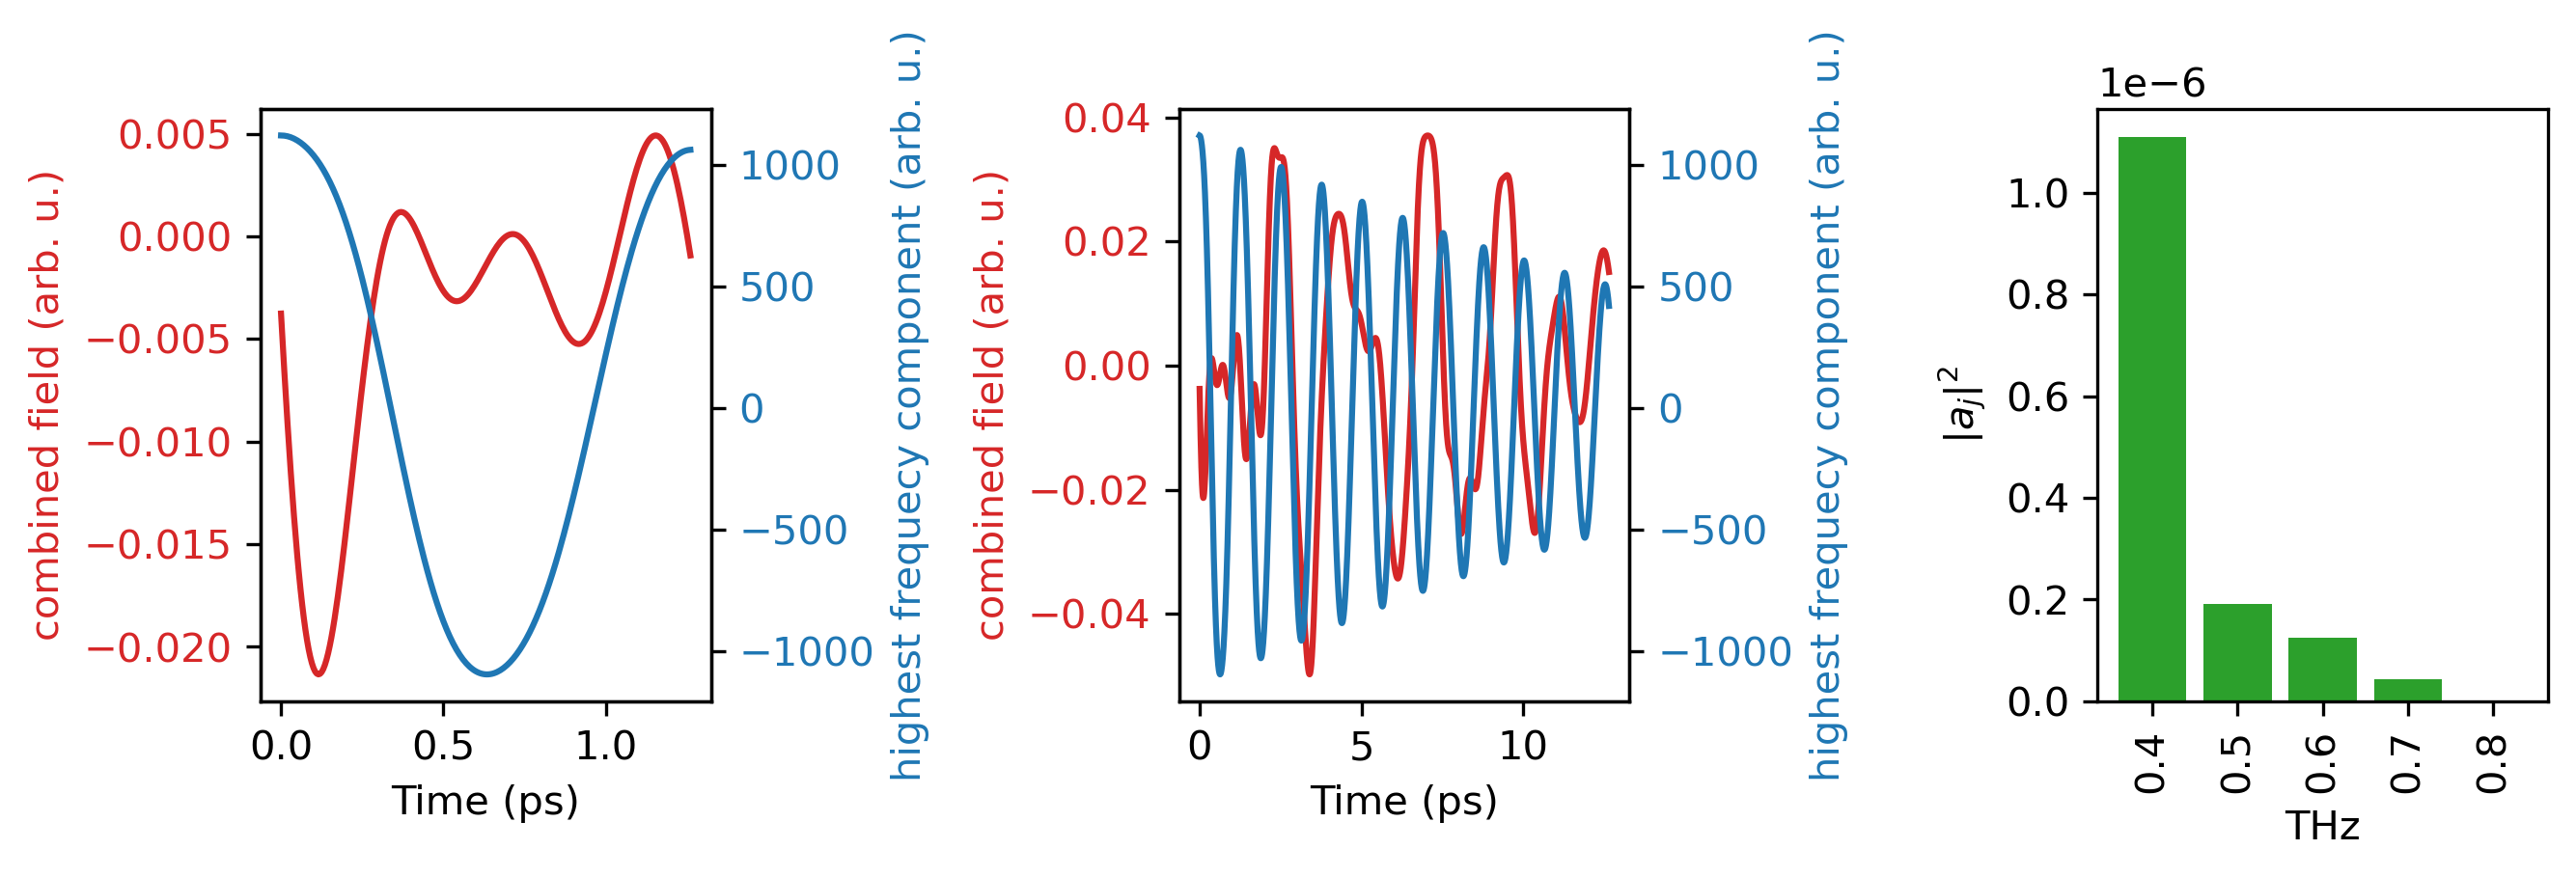

(5,)


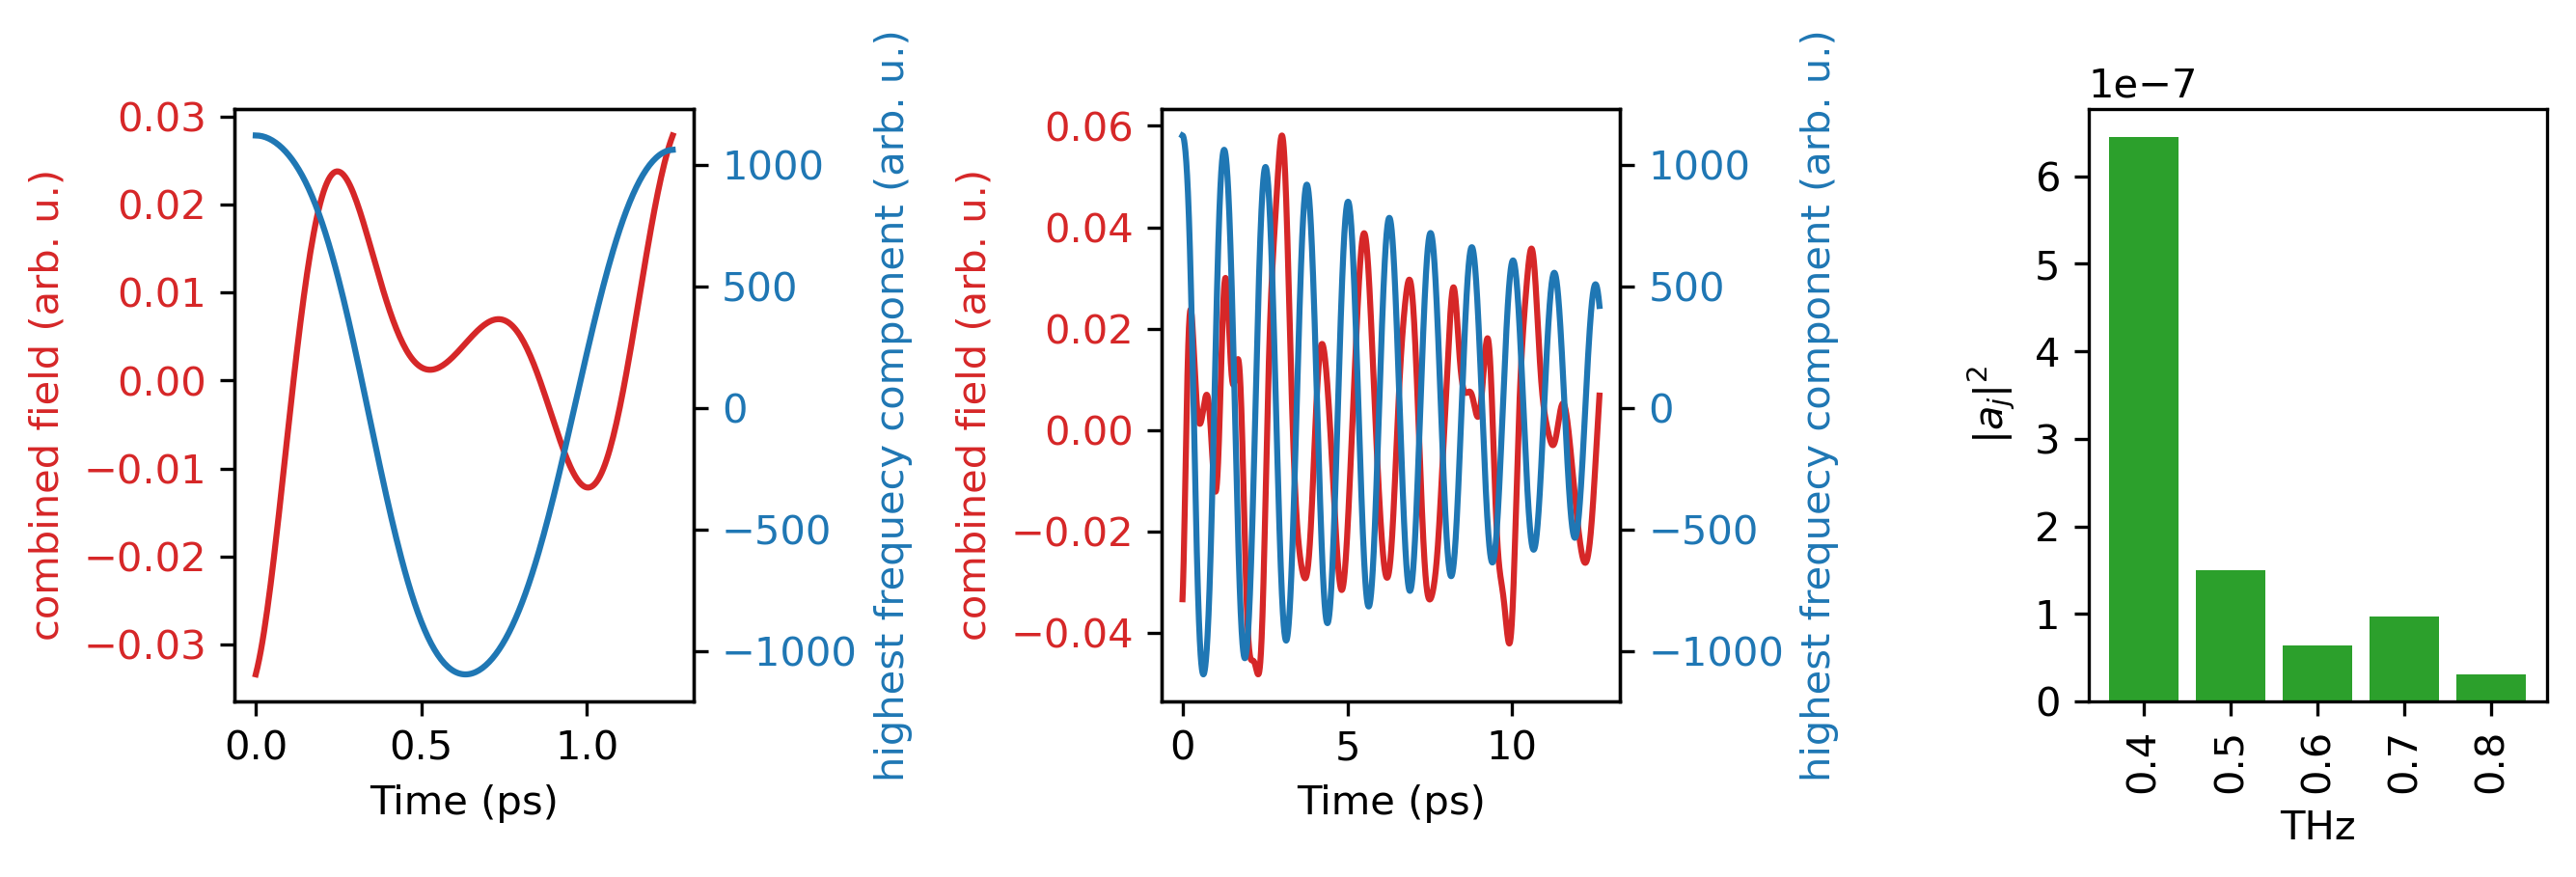

(5,)


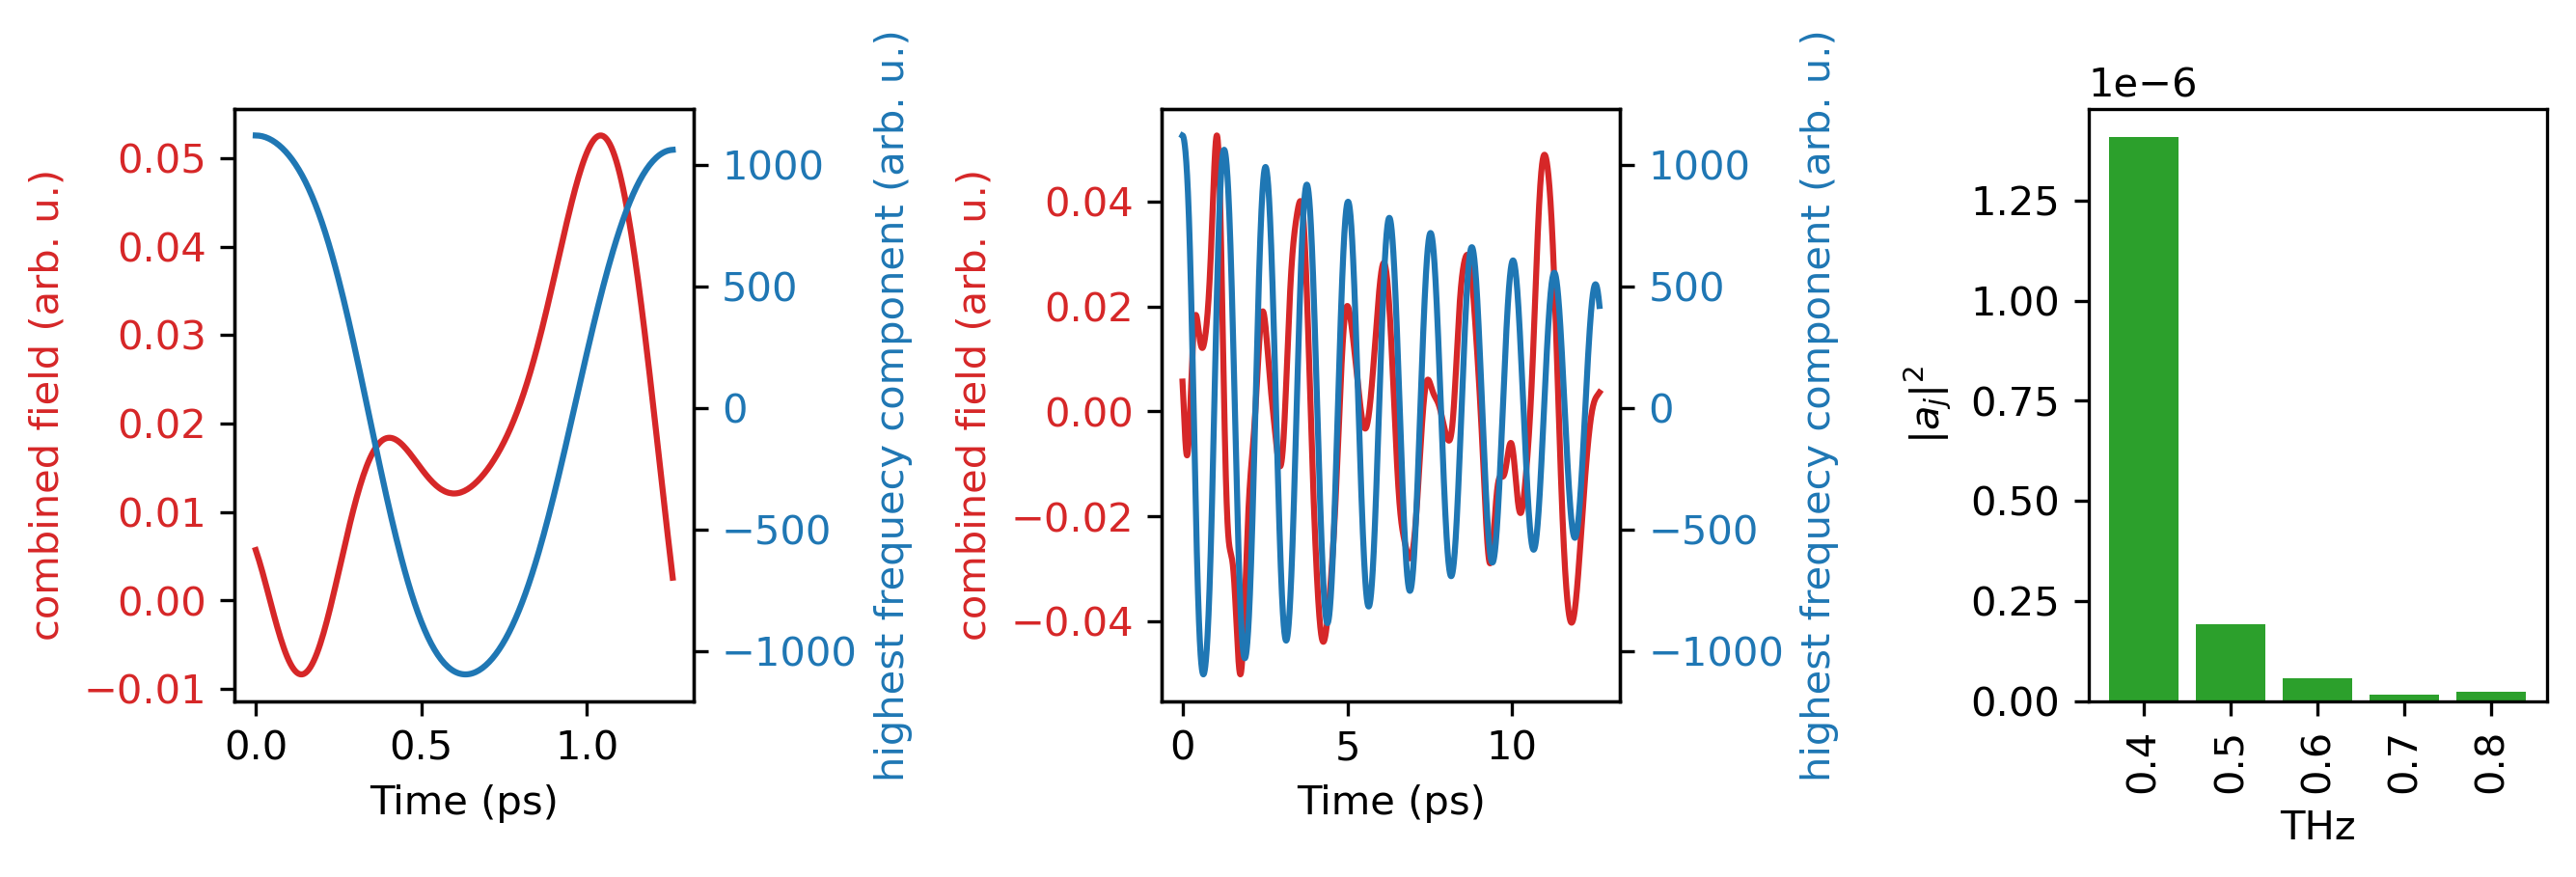

(5,)


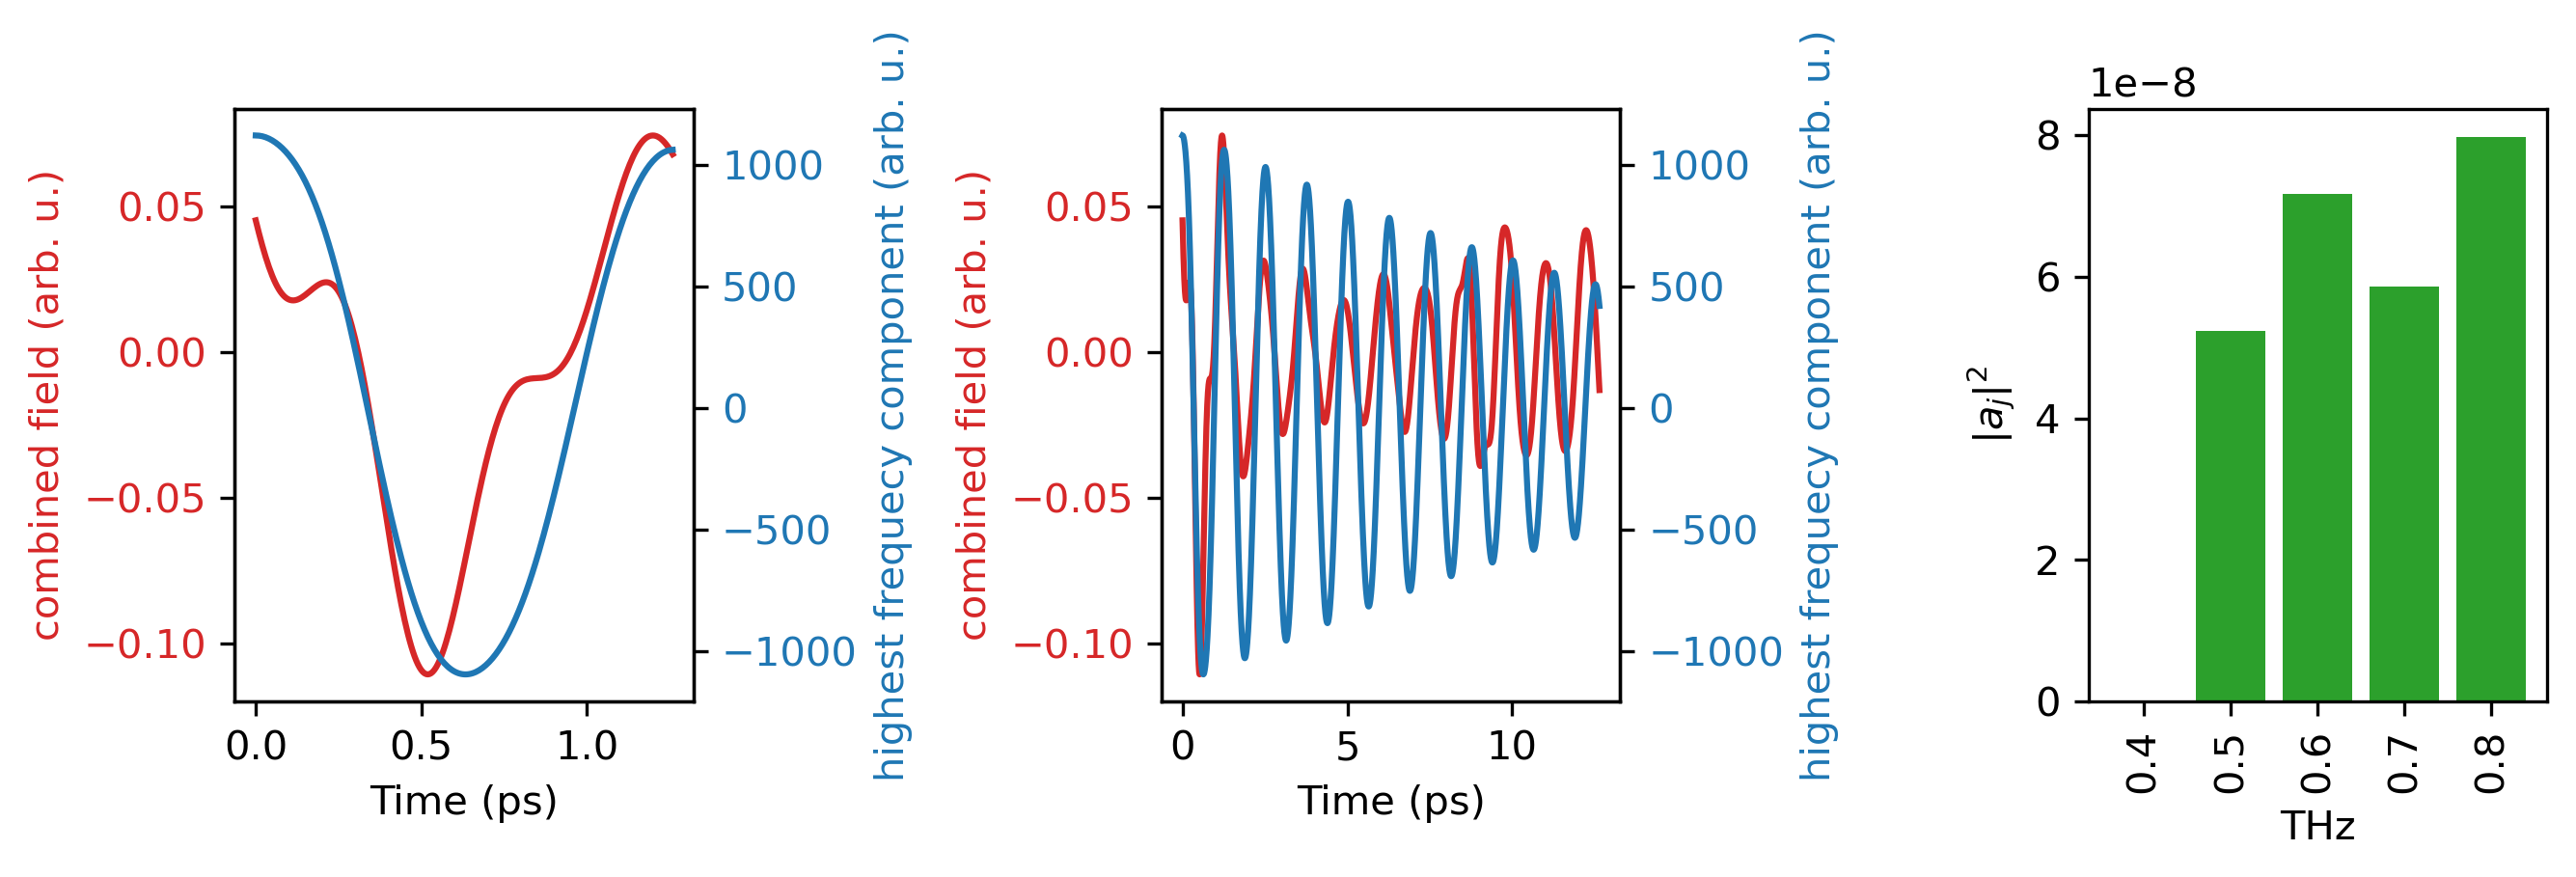

In [40]:
largest_freq_pulse = sample_no_lactose.pulses[sample_no_lactose.largest_freq]
omega = sample_no_lactose.omega

for num, eig_vector in enumerate(vecs.T):
    
    # get superoscilating fields
    field = delta_pulses @ eig_vector
    
    # a sanity check
    assert np.allclose(eig_vector.T @ sample_no_lactose.S_infty @ eig_vector, 1.)
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:observational_window], field[:observational_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
        
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:observational_window], largest_freq_pulse[:observational_window], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot zoom out view
    larger_window = 10 * observational_window
    
    ax1 = ax1_
    
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:larger_window], field[:larger_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:larger_window], largest_freq_pulse[:larger_window])
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), np.abs(eig_vector) ** 2, color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(omega, rotation='vertical')
    ax1.set_xlabel('THz')
    ax1.set_ylabel('$|a_j|^2$')
    
    fig.tight_layout()
    
    plt.savefig('fig_{}.pdf'.format(num), transparent=True)
    
    plt.show()

## Scanning the values of observational windows

In [16]:
def get_opt_field(obs_window):
    """
    Compute the optimal strategy for a given observational time window 
    """
    # Form the overlap matrix for a given observational window 
    S_observ = get_overlap(
        delta_pulses[:obs_window], 
        times[:obs_window]
    )
    
    # Extract the largest eigenvalue and eigenvector 
    n = S_observ.shape[0]
    intensity, vec = eigh(
        S_observ, 
        sample_no_lactose.S_infty, 
        subset_by_index=[n-1, n-1]
    )
    
    return intensity[0] / (times[obs_window - 1] - times[0]), vec 

In [58]:
largest_freq_period = sample_no_lactose.observational_window

observational_windows = np.logspace(
    np.log10(0.5 * largest_freq_period), 
    np.log10(20 * largest_freq_period), 
    100,
    dtype=np.int
)

vals, vecs = zip(*
    [get_opt_field(_) for _ in observational_windows]
)
vals = np.array(vals)
vecs = np.array(vecs)

# Specify which eigenvectors to plot 
n = observational_windows.size
vecs_to_plot =  np.array(
     [0, 
      np.searchsorted(observational_windows, largest_freq_period), 
      int(n / 2),
      n-1]
 )


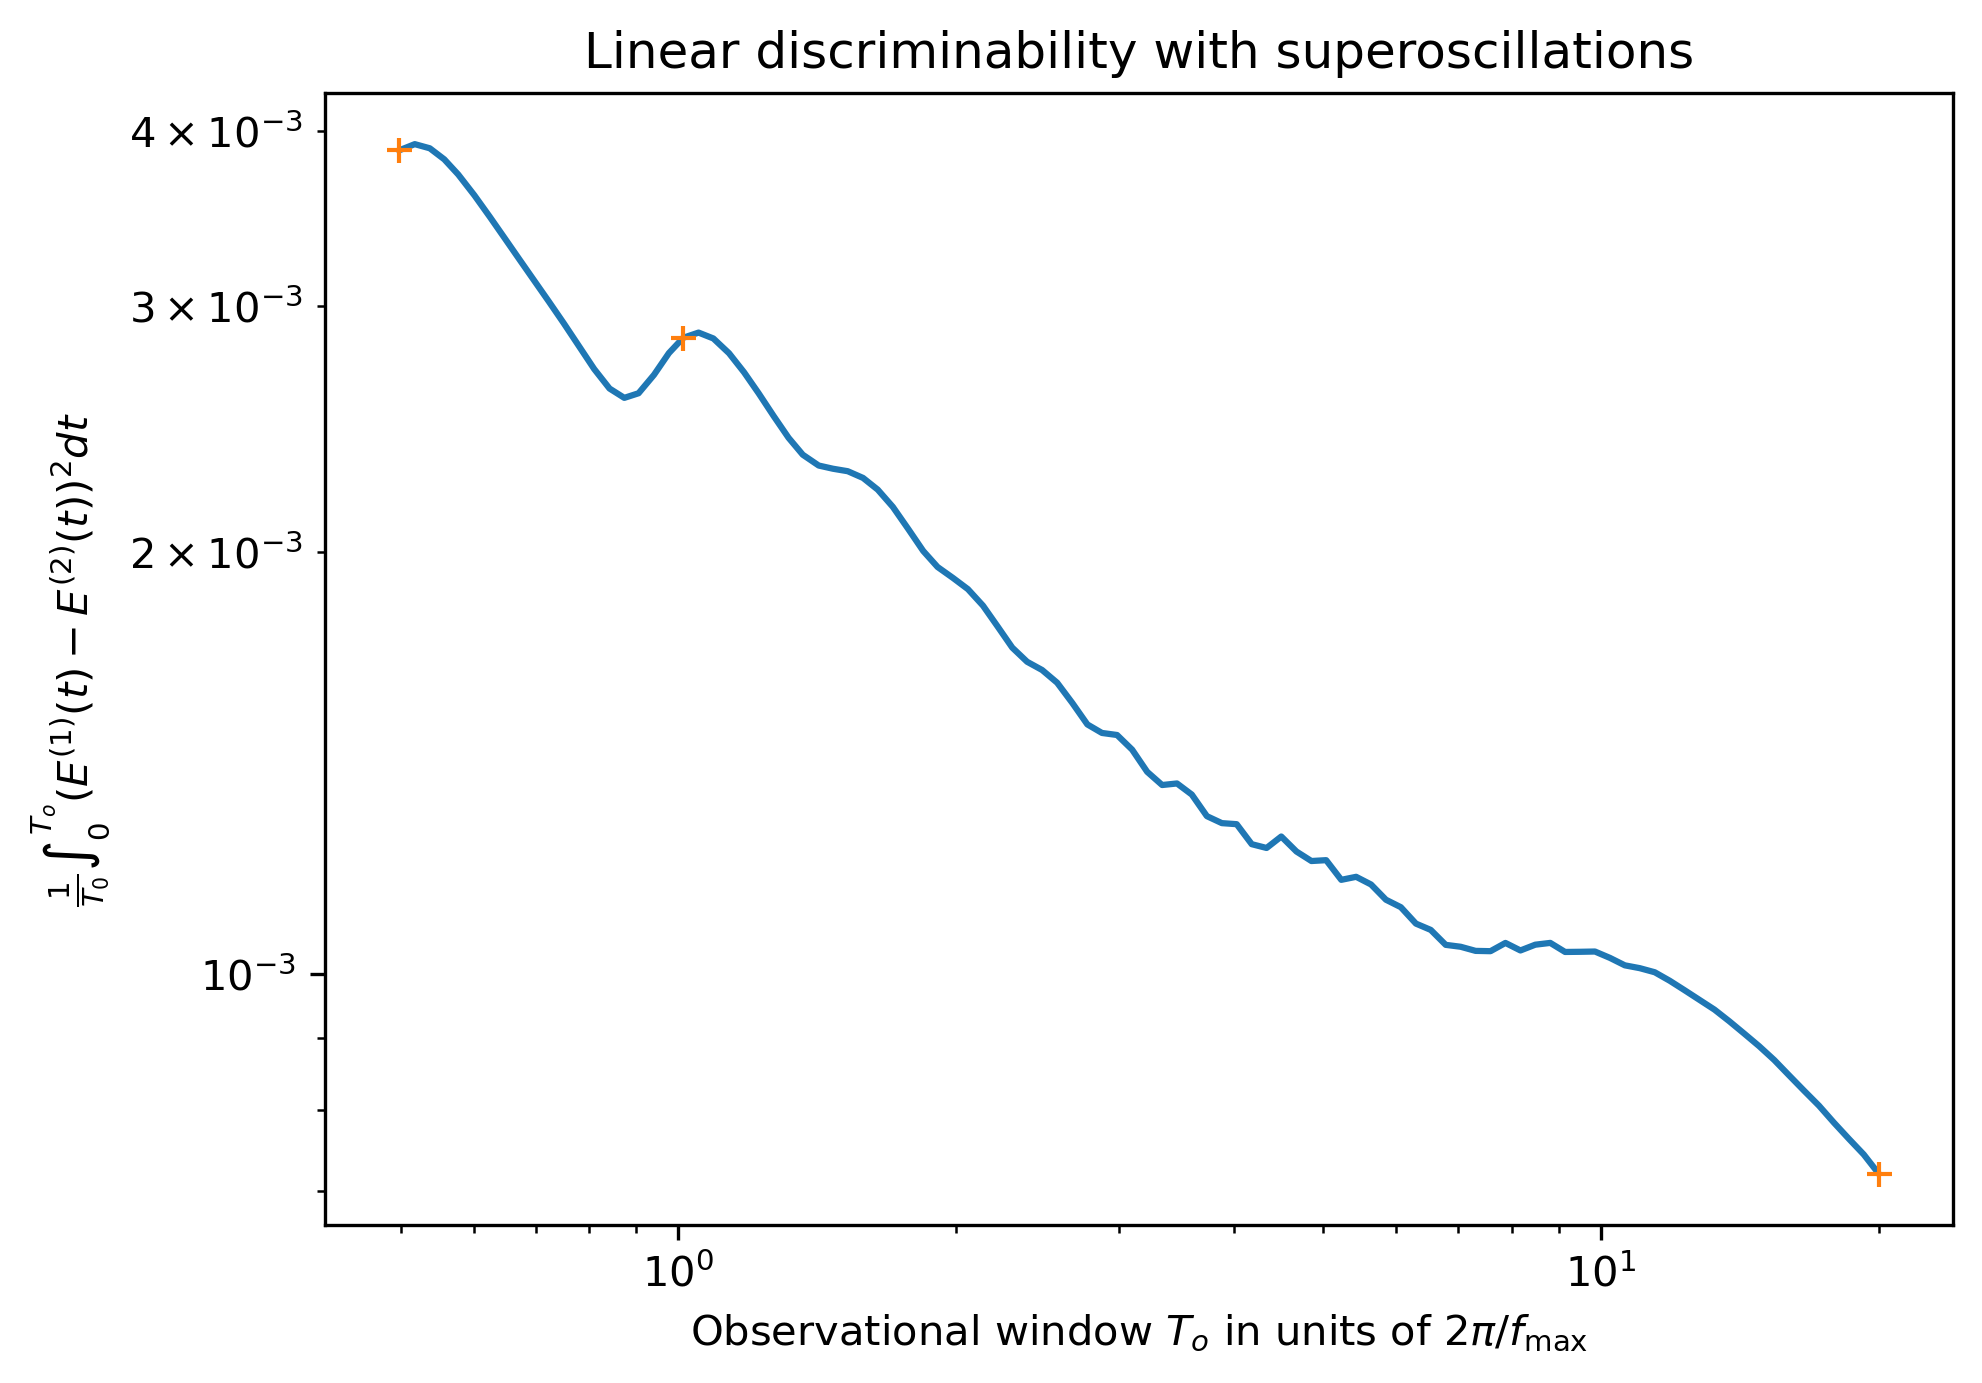

In [59]:
plt.figure(figsize=(7, 5), dpi=300)
plt.title('Linear discriminability with superoscillations')

plt.loglog(observational_windows / largest_freq_period, vals)

plt.loglog(
    observational_windows[vecs_to_plot] / largest_freq_period, 
    vals[vecs_to_plot],
    '+',
)

plt.xlabel(r'Observational window $T_o$ in units of $2\pi/f_{\max}$')
plt.ylabel(r'$\frac{1}{T_0}\int_0^{T_o} (E^{(1)}(t) - E^{(2)}(t))^2 dt$')

plt.show()

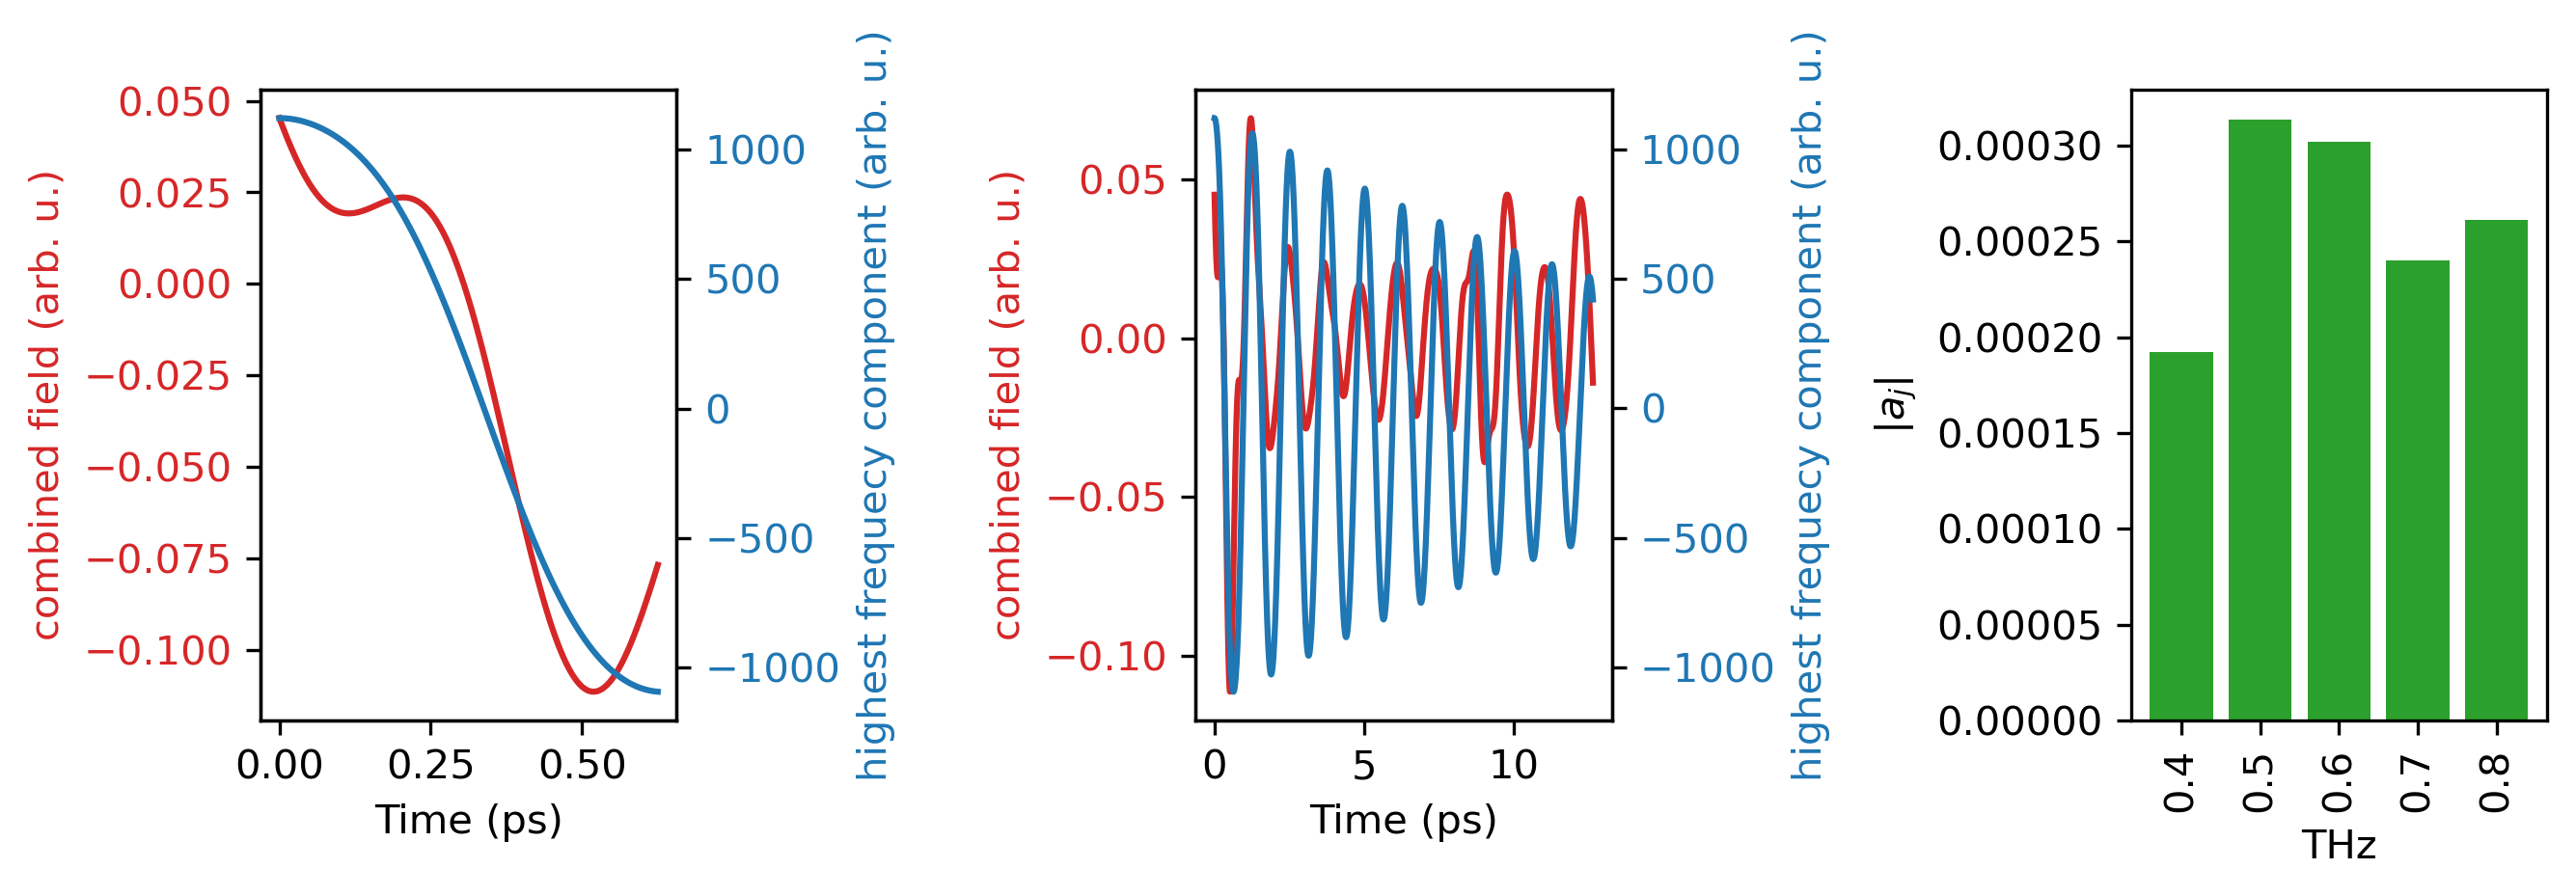

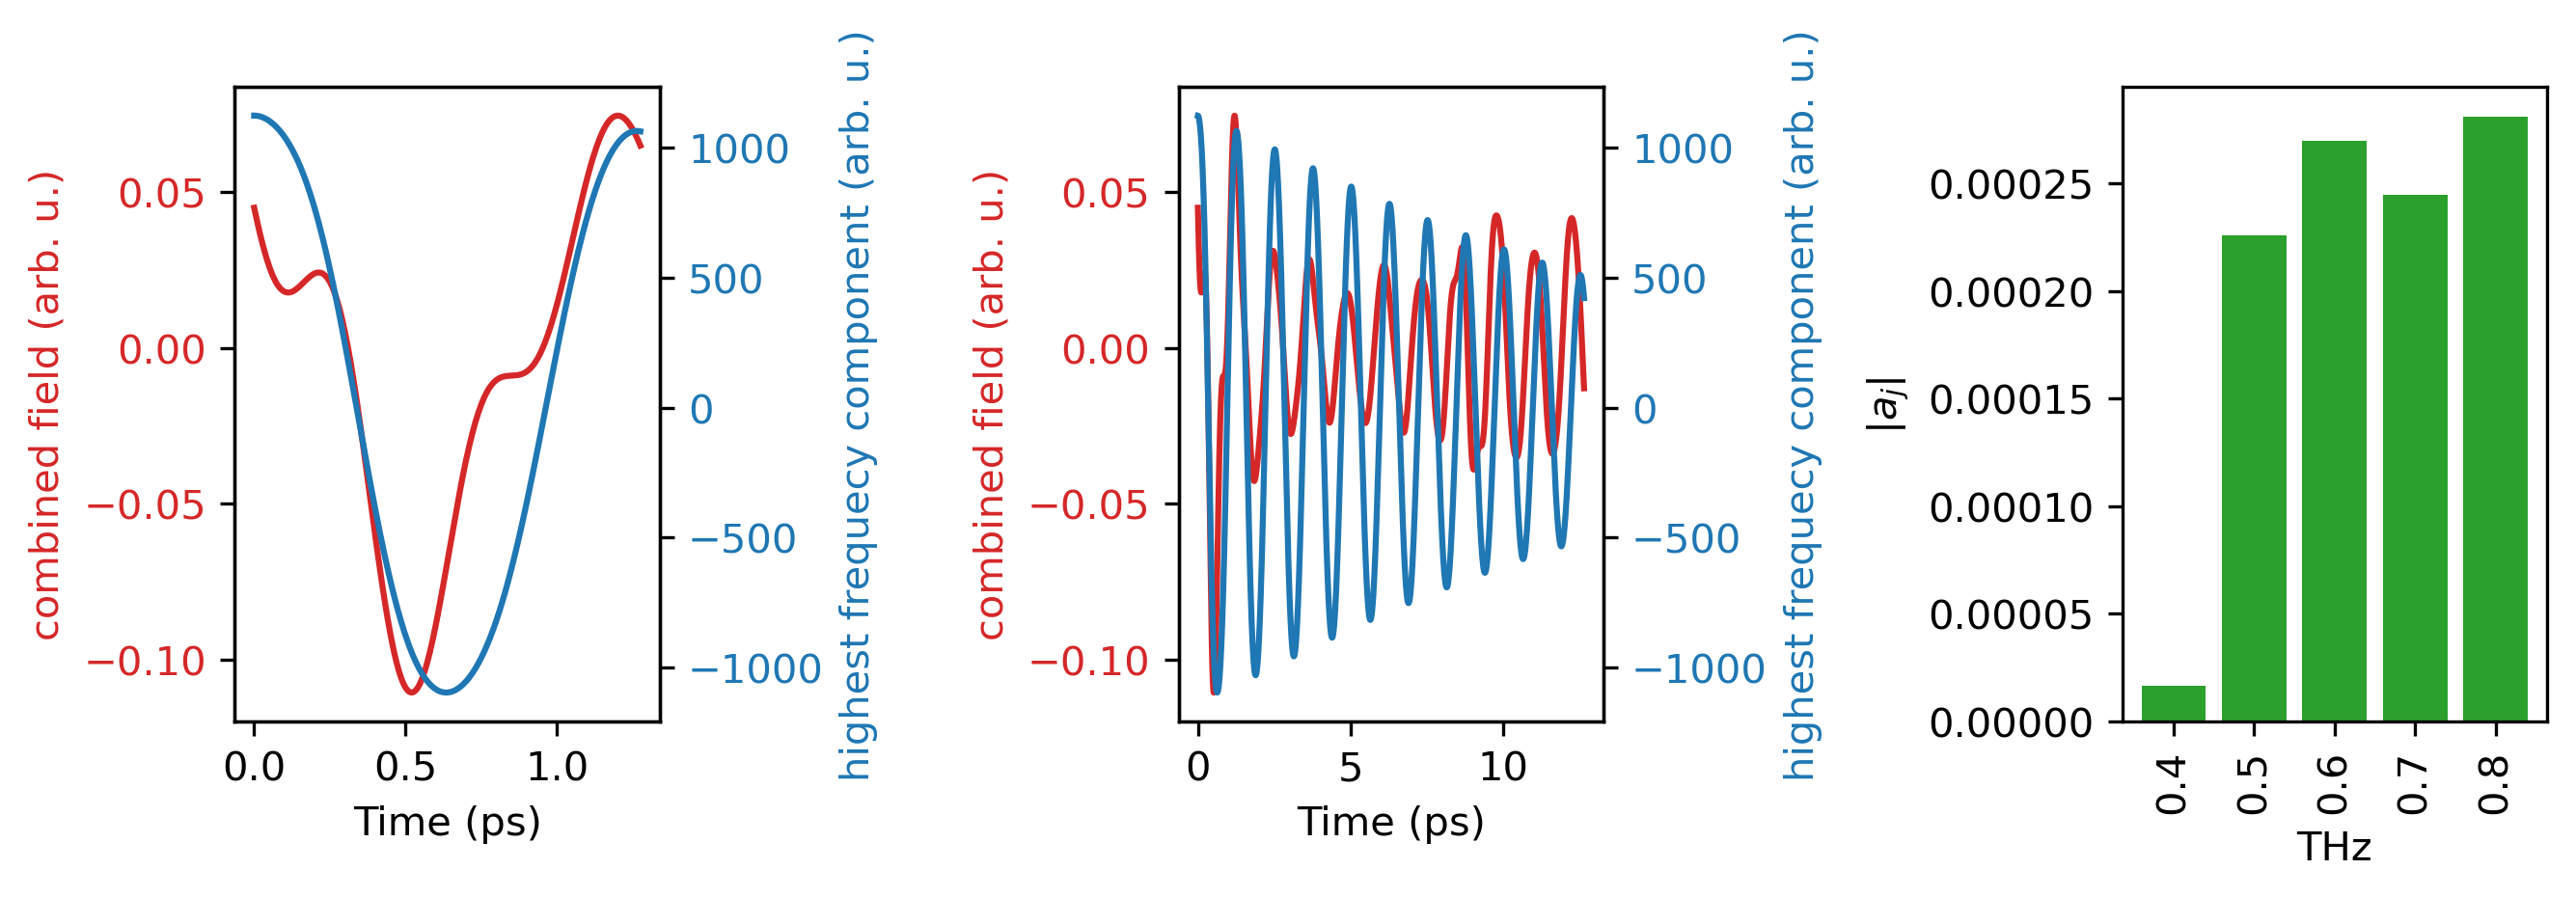

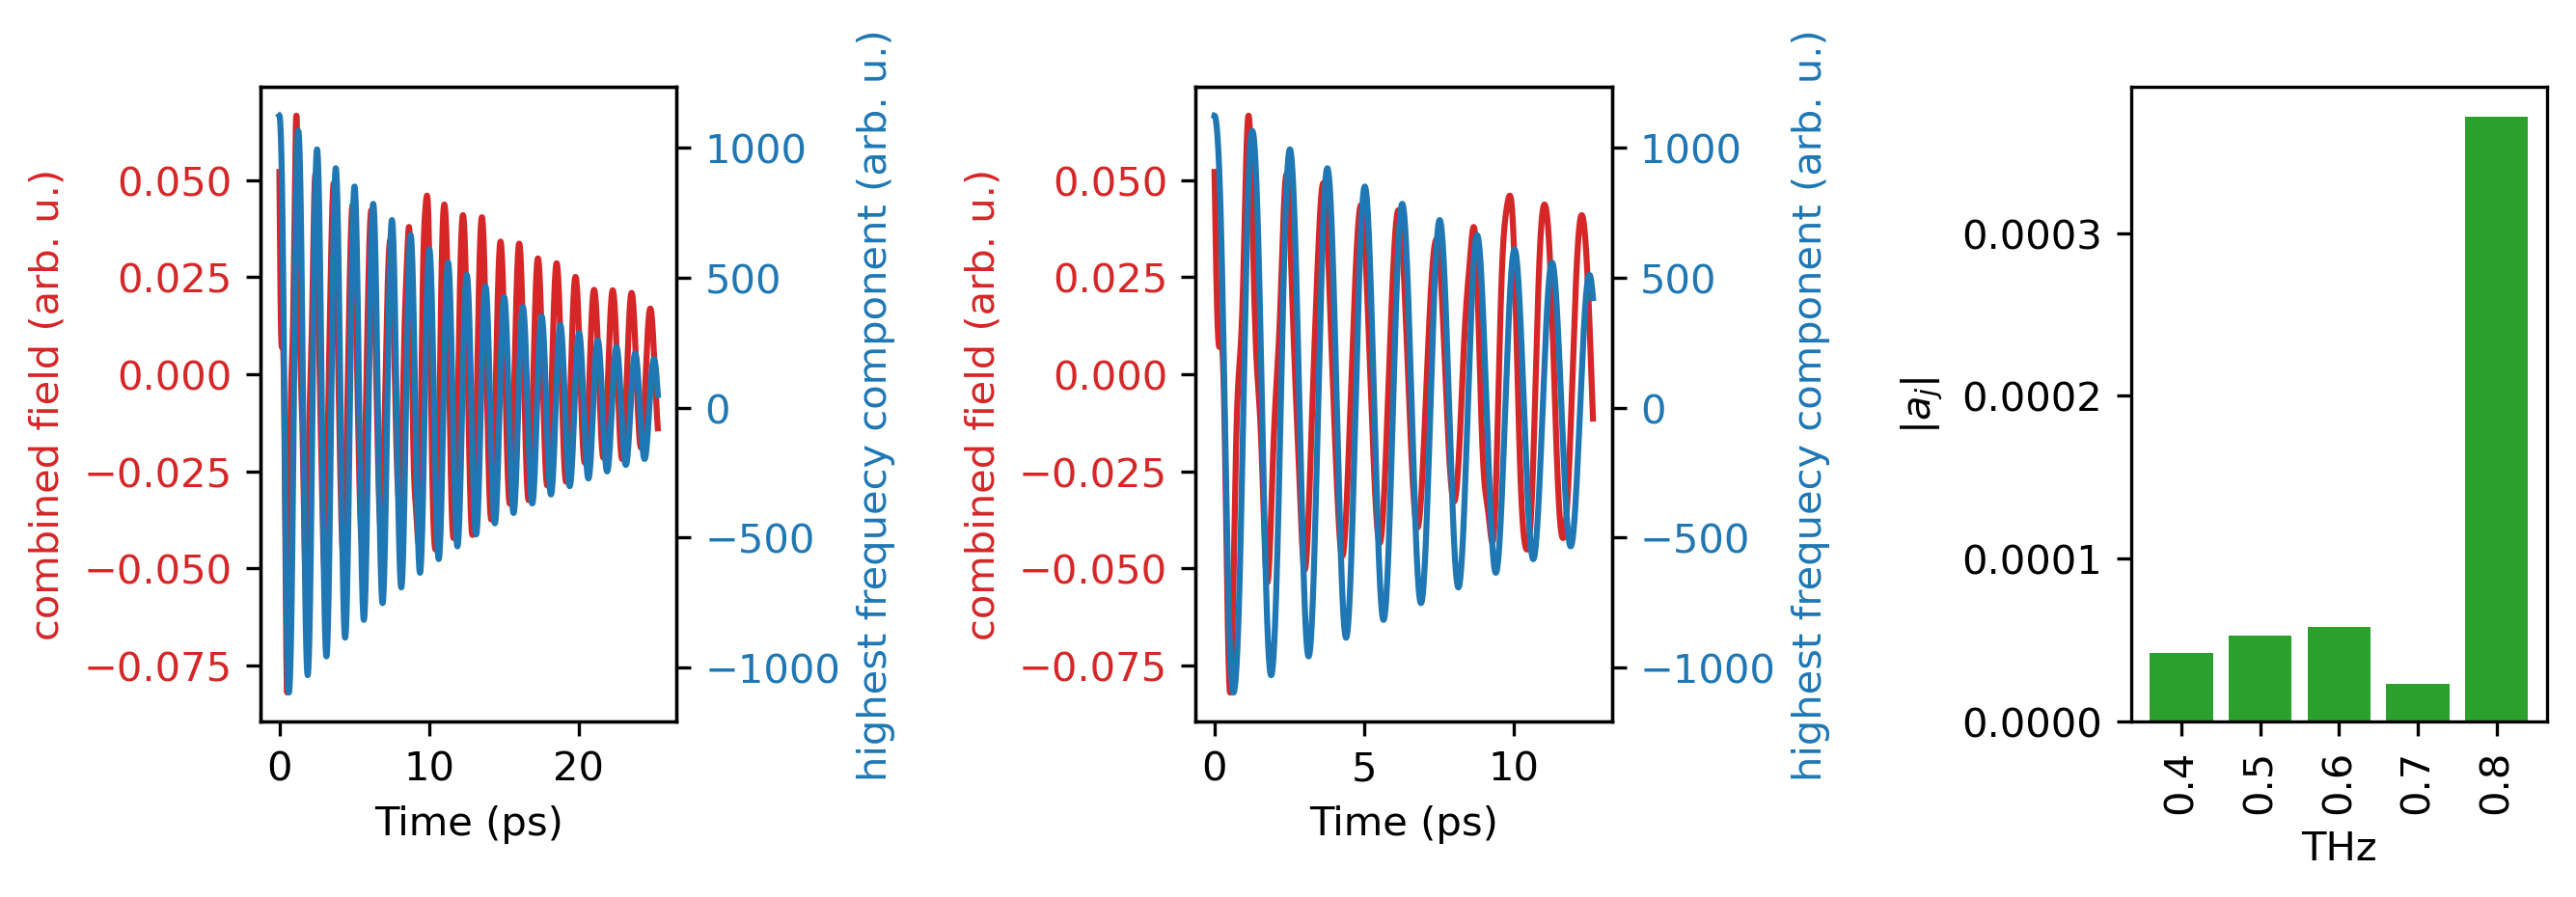

In [60]:
for indx in vecs_to_plot:
    
    eig_vector = vecs[indx].reshape(-1)
    observational_window = observational_windows[indx]
    
    # get superoscilating fields
    field = delta_pulses @ eig_vector
    
    # a sanity check
    assert np.allclose(eig_vector.T @ sample_no_lactose.S_infty @ eig_vector, 1.)
    
    # plot zoom in view
    fig, (ax1, ax1_, ax1__) = plt.subplots(1, 3, figsize=(9, 3), dpi=300)
    
    color1 = 'tab:red'
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:observational_window], field[:observational_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    color2 = 'tab:blue'
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:observational_window], largest_freq_pulse[:observational_window], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot zoom out view
    larger_window = 10 * largest_freq_period
    
    ax1 = ax1_
    
    ax1.set_ylabel('combined field (arb. u.)', color=color1)
    ax1.plot(times[:larger_window], field[:larger_window], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    ax1.set_xlabel(timecol)
    
    ax2 = ax1.twinx() 
    
    ax2.set_ylabel('highest frequecy component (arb. u.)', color=color2)
    ax2.plot(times[:larger_window], largest_freq_pulse[:larger_window])
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # plot pulses
    ax1 = ax1__
    
    ax1.bar(np.arange(eig_vector.size), np.abs(eig_vector), color='tab:green')
    ax1.set_xticks(np.arange(eig_vector.size))
    ax1.set_xticklabels(omega, rotation='vertical')
    ax1.set_xlabel('THz')
    ax1.set_ylabel('$|a_j|$')
    
    fig.tight_layout()
    
    #plt.savefig('fig_{}.pdf'.format(indx), transparent=True)
    
    plt.show()